Ce notebook étudie l’action **NVIDIA (NVDA)** sur la période **2015–2024** à partir de données quotidiennes de marché. L’analyse se concentre sur l’**activité de marché** du titre, mesurée par le **volume de transactions**, tout en replaçant NVDA dans son environnement (marché global, technologie, semi-conducteurs, régime de risque et conditions financières) afin de distinguer ce qui relève de dynamiques propres au titre et ce qui s’explique par des facteurs plus systémiques.

La question centrale du projet est la suivante : **comment quantifier la montée en puissance boursière de NVIDIA et, dans cette optique, prévoir le volume de transactions du titre au jour (t+1) à partir des informations disponibles jusqu’au jour (t)** ? L’enjeu est double : produire une lecture descriptive rigoureuse des dynamiques de NVDA (tendances, volatilité, épisodes extrêmes, comparaison marché/secteur) et tester, dans un cadre temporel réaliste, la capacité de variables internes (rendements, volatilité réalisée, inertie du volume) et externes (ETFs, VIX, taux US 10 ans) à améliorer la prévision de (Volume_{t+1}).

Le notebook suit une progression naturelle en trois étapes. 
- 1) On commence par construire une base de travail fiable : récupération des séries, mise au bon format, alignement temporel, contrôle qualité et sauvegarde systématique de versions brutes et traitées pour garantir la reproductibilité. 
- 2) On passe ensuite à l’analyse descriptive et aux visualisations, pour faire émerger des faits stylisés simples (régimes de volatilité, corrections, co-mouvements avec le marché et le secteur) qui guideront la suite. 
- 3) Enfin, on aborde la modélisation de prévision à un pas de temps : définition de la cible (Volume_{t+1}), construction des variables explicatives disponibles à (t), comparaison à une baseline naïve, entraînement de modèles candidats, interprétation des signaux utilisés et évaluation strictement chronologique (split temporel puis validation croisée temporelle) afin d’éviter toute fuite d’information et de mesurer la robustesse des résultats dans le temps.

Sommaire générique : 
- **A Récupération et préparation des données**
  - **A.1 — Importation des données**
  - **A.1.2 — Merge / Fusion**
  - **A.2 — Nettoyage et manipulation des données**

- **B Analyse descriptive et visualisation**
  - **B.1 — Préparation des variables descriptives**
  - **B.2 — Prix de NVDA et tendances (moyennes mobiles)**
  - **B.3 — Rendements et volatilité réalisée**
  - **B.4 — Mise en contexte : marché, secteur et régime de risque**
  - **B.5 — Distribution des rendements et épisodes extrêmes**
  - **B.6 — Corrélations ciblées (sur variations)**

- **C — Modélisation : Forecast du volume (t+1)**
  - **C.1 — Modèles candidats et protocole d’évaluation**
  - **C.2 — Comprendre “ce qui drive” les prédictions (interprétabilité)**
  - **C.3 — Validation croisée temporelle (TimeSeriesSplit)**



---
# A. Données

Pour répondre à notre question, la première étape consiste à construire une base de données **cohérente dans le temps** et **facile à rejouer**. L’idée est simple : le volume de NVDA ne dépend pas uniquement de “NVDA tout seul”, mais aussi du **contexte de marché** (journées calmes vs stressées, chocs sectoriels, conditions financières). On a donc besoin de données qui décrivent à la fois l’actif et son environnement.

On utilise deux sources courantes pour la data financière :

- **Yahoo Finance via `yfinance`**, parce que c’est une solution très pratique pour obtenir des séries *daily* au format **OHLCV** (Open, High, Low, Close, Volume).  
  Pour les transformations de prix (rendements, volatilité), on s’appuie autant que possible sur des **prix ajustés** (*Adjusted Close*), afin de ne pas introduire de ruptures artificielles liées aux **splits** et **dividendes**.

- **FRED via `pandas-datareader`**, qui donne accès à des séries macro-financières largement utilisées (taux, indicateurs de stress), avec une logique plus “officielle” et structurée.

Concrètement, la base est construite en combinant trois blocs complémentaires :

1. **NVDA (Yahoo Finance)**  
   C’est le cœur du projet : on récupère les prix et le volume quotidiens de NVIDIA. Les informations associées (prix ajustés / splits / dividendes) servent surtout à travailler avec des variables comparables dans le temps.

2. **ETFs (Yahoo Finance) — SPY / QQQ / SOXX**  
   Ces séries donnent le **thermomètre du marché** :  
   - *SPY* (marché US large),  
   - *QQQ* (exposition tech),  
   - *SOXX* (secteur semi-conducteurs).  
   L’objectif est de capter les chocs “systématiques” (marché/secteur) et de mieux isoler ce qui est spécifique à NVDA.

3. **Variables de régime (FRED) — VIX et taux US 10 ans**  
   - **VIX** : indicateur de régime de volatilité (calme vs stress).  
   - **10Y** : proxy simple des conditions financières via les taux longs.

Enfin, toutes les séries sont **alignées sur un calendrier unique** (les dates de cotation de NVDA). C’est un point crucial : à chaque ligne (chaque date), toutes les variables doivent correspondre au **même instant d’information**, sinon on crée des décalages qui faussent l’analyse et la prédiction.

Pour finir, on sauvegarde systématiquement les données en deux étapes :
- **raw** : données téléchargées telles quelles (trace de la source),
- **processed** : version nettoyée et alignée, prête pour l’EDA et la modélisation,

afin que le notebook soit **reproductible** et qu’on puisse le relancer sans dépendre d’un nouveau téléchargement.


---
## A.1 — Importation des données

Dans cette partie, on met en place la base de données qui servira pour tout le reste du projet. L’objectif n’est pas seulement de “télécharger des séries”, mais de construire un **dataset unique**, propre et cohérent, sur lequel on pourra ensuite faire de l’analyse descriptive puis de la prédiction.

Concrètement, on récupère **trois blocs de données complémentaires** (NVDA, ETFs et indicateurs FRED) et on les **fusionne dans une seule table**, alignée sur un calendrier commun. À la fin de cette étape, chaque ligne du dataset correspond à une date de cotation, et toutes les variables (marché, secteur, macro) décrivent le **même instant d’information**, condition indispensable avant toute modélisation.


On commence par importer les bibliothèques nécessaires (imports) pour la suite du projet.

In [73]:
import pandas as pd
from pandas_datareader import data as web
from pathlib import Path
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

On définit d’abord les **chemins de fichiers** (*paths*) : ce sont tout simplement les emplacements (dossiers/nom de fichiers) où l’on va **sauvegarder** les données sur la machine, par exemple dans `data/raw/` (données brutes) puis `data/processed/` (données nettoyées).  

On fixe ensuite les **paramètres d’extraction** : la période (dates de début/fin) et la liste des tickers à récupérer via Yahoo Finance.


In [41]:
#Période d’étude : 10 ans
start_date = "2015-01-01"
end_date   = "2024-12-31"

#Sélection des tickers/séries d’intérêt (ETFs + indicateurs macro) 
etf_tickers  = ["SPY", "QQQ", "SOXX"]
fred_series  = ["VIXCLS", "DGS10"]
ticker = "NVDA"

#Gestion des paths : création du dossier raw et définition des fichiers de sauvegarde
RAW_DIR = Path("data/raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)
nvda_raw_path = RAW_DIR / "nvda_stock_data_raw.csv"
etf_raw_path  = RAW_DIR / "etf_stock_data_raw.csv"
fred_raw_path = RAW_DIR / "fred_macro_raw.csv"

### A.1.1 - Téléchargements

On télécharge ensuite les trois blocs de données (NVDA, ETFs et séries FRED) et on les affiche systématiquement afin de vérifier rapidement que la sortie est cohérente : format des données, variables disponibles et ordre chronologique.

In [42]:
## Téléchargement des données de NVIDIA (Close = Close ajusté)

# Si le fichier raw existe déjà, on le recharge
if nvda_raw_path.exists():
    nvda_data = pd.read_csv(nvda_raw_path, parse_dates=["Date"])

# Sinon, on télécharge NVDA via Yahoo
else:
    nvda_data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=True,   # => Close (et OHLC) ajustés splits/dividendes
        actions=True,
        progress=False
    ).reset_index()

    nvda_data = nvda_data.rename(
        columns={c: f"{c}_{ticker}" for c in nvda_data.columns if c != "Date"}
    )

    # Save en cache pour la reproductibilité
    nvda_data.to_csv(nvda_raw_path, index=False)

# Affichage de contrôle
nvda_data.head()


Price,Date,Close,Dividends,High,Low,Open,Stock Splits,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
0,2015-01-02,0.483011,0.0,0.486611,0.475333,0.483011,0.0,113680000
1,2015-01-05,0.474853,0.0,0.484451,0.472694,0.483011,0.0,197952000
2,2015-01-06,0.460456,0.0,0.476053,0.459977,0.475573,0.0,197764000
3,2015-01-07,0.459257,0.0,0.467895,0.457817,0.463816,0.0,321808000
4,2015-01-08,0.476533,0.0,0.479412,0.464296,0.464536,0.0,283780000


### Close “normal” vs Close ajusté (Adjusted)

Sur Yahoo Finance, on peut récupérer deux notions de prix :

- **Close (non ajusté)** : c’est le dernier prix de la journée tel qu’il a été coté, sans correction.
- **Close ajusté (Adjusted Close)** : c’est un prix **corrigé** des événements “corporate actions”, principalement :
  - **splits** (ex. division par 10 du prix, qui ne change pas la valeur économique détenue),
  - **dividendes** (qui font baisser mécaniquement le prix à la date ex-dividend).

Pourquoi c’est important ?  
Si on calcule des **rendements** ou une **volatilité** à partir d’un *Close non ajusté*, un split crée une **rupture artificielle** (un faux “krach” ou une fausse “hausse”) qui n’a rien à voir avec le marché. Cela fausse l’EDA (graphes, stats) et peut aussi contaminer les variables explicatives utilisées par les modèles.

**Démarche retenue dans ce projet**  
Pour éviter ce biais, on choisit de travailler avec des **prix ajustés**. Concrètement, `yfinance` permet de le faire directement via `auto_adjust=True` : les colonnes OHLC retournées sont alors ajustées, et la colonne `Close` correspond à un prix cohérent dans le temps (split/dividendes intégrés). On conserve malgré tout le **Volume** tel quel, car il n’a pas besoin du même type d’ajustement.

Cette décision garantit que les transformations basées sur les prix (rendements, volatilité, etc.) reflètent bien des variations économiques réelles, et non des effets purement mécaniques.


In [44]:
## Téléchargement ETFs + FRED (Close ajusté pour ETFs)

# ETFs
if etf_raw_path.exists():
    etf_data = pd.read_csv(etf_raw_path, parse_dates=["Date"])
else:
    etf = yf.download(
        etf_tickers,
        start=start_date,
        end=end_date,
        group_by="column",
        auto_adjust=True,   # <= important : OHLC ajustés
        progress=False
    )
    etf.columns = [f"{field}_{tic}" for field, tic in etf.columns]
    etf_data = etf.reset_index()
    etf_data.to_csv(etf_raw_path, index=False)

# FRED (VIXCLS, DGS10)
if fred_raw_path.exists():
    fred_data = pd.read_csv(fred_raw_path, parse_dates=["DATE"])
else:
    fred_data = web.DataReader(fred_series, "fred", start_date, end_date).reset_index()
    fred_data.to_csv(fred_raw_path, index=False)

# Harmonisation du nom de la date pour faciliter les merges
fred_data = fred_data.rename(columns={"DATE": "Date"})

# Affichages de contrôle
fred_data.head()
etf_data.head()


,Date,Close_QQQ,Close_SOXX,Close_SPY,High_QQQ,High_SOXX,High_SPY,Low_QQQ,Low_SOXX,Low_SPY,Open_QQQ,Open_SOXX,Open_SPY,Volume_QQQ,Volume_SOXX,Volume_SPY
0,2015-01-02,94.784431,27.559076,170.589569,95.944601,27.861956,171.793663,94.324045,27.300739,169.551566,95.539465,27.704578,171.378462,31314600,663000,121465900
1,2015-01-05,93.394058,27.039425,167.508835,94.480571,27.493744,169.709397,93.127033,27.030516,167.201590,94.370076,27.443266,169.543319,36521300,619500,169632600
2,2015-01-06,92.141808,26.436634,165.931015,93.688707,27.083966,168.339177,91.727462,26.359430,165.133823,93.532178,27.057240,167.816019,66205500,1123800,209151400
3,2015-01-07,93.329590,26.697943,167.998749,93.550573,26.816719,168.339217,92.528514,26.430697,166.811279,92.749505,26.588075,167.259691,37577400,721200,125346700
4,2015-01-08,95.115921,27.490770,170.979874,95.300073,27.535311,171.195786,94.020198,26.968154,169.393814,94.121484,26.968154,169.410413,40212600,633000,147217800


Cette cellule complète la base en ajoutant deux types d’informations utiles pour expliquer le comportement de NVDA. 

Précisions sur les ETFs récupérés :
- *SPY* :
L’idée est de capter les mouvements systématiques (risk-on / risk-off) qui affectent presque toutes les actions. Si NVDA bouge “comme le marché”, SPY permet de l’expliquer et d’éviter d’attribuer à NVDA ce qui relève en réalité d’un choc global.

- *QQQ* :
NVDA est typiquement une valeur croissance/tech, donc ses variations (et souvent son volume) réagissent fortement aux dynamiques propres à ce segment (révisions de taux, rotations value→growth, etc.). QQQ capture mieux cette composante que SPY, plus diversifié.

- *SOXX* : 
NVDA appartient aux semi-conducteurs : annonces sur l’industrie, cycles de demande (GPU, data centers), contraintes d’offre, news concurrentielles… peuvent bouger tout le secteur.

Pour la suite garder en tête que l'on a : 
- ce qui est “marché” (SPY),
- ce qui est “tech” (QQQ),
- ce qui est “semi-conducteurs” (SOXX),
- ce qui reste spécifique à NVDA (idiosyncratique).

Comme pour NVDA, on télécharge ces séries via `yfinance` et on active `auto_adjust=True`.  

Enfin, pour la **reproductibilité**, on applique la même logique que précédemment :
- si les fichiers existent déjà (cache), on les recharge ;
- sinon, on télécharge puis on sauvegarde en local.
On harmonise aussi le nom de la colonne de date (`DATE` → `Date`) pour faciliter les fusions par la suite.

### A.1.2 — Création de la base principale : `nvda_data_2`

Ensuite, on fusionne les trois bases (NVDA, ETFs et FRED) afin d’obtenir un dataset unique, prêt pour les étapes de contrôle qualité et de préparation des variables.

In [45]:
## Création de la base finale
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Aplatit les colonnes si MultiIndex (ex: ('Close','NVDA') -> 'Close_NVDA')."""
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = [
            "_".join([str(x) for x in tup if x not in [None, ""]])
            for tup in df.columns.to_list()
        ]
    return df

# 1) Robustesse colonnes
nvda_data = flatten_cols(nvda_data)
etf_data  = flatten_cols(etf_data)

# 2) Harmonisation de la colonne date pour FRED
if "DATE" in fred_data.columns and "Date" not in fred_data.columns:
    fred_data = fred_data.rename(columns={"DATE": "Date"})

# 3) S’assurer que NVDA est suffixé _NVDA (sauf Date)
if not any(str(c).endswith("_NVDA") for c in nvda_data.columns if c != "Date"):
    nvda_data = nvda_data.rename(columns={c: f"{c}_NVDA" for c in nvda_data.columns if c != "Date"})

# Base NVDA clean
nvda_cols = ["Date"] + [c for c in nvda_data.columns if str(c).endswith("_NVDA")]
nvda_base = nvda_data[nvda_cols].copy()

# 4) Format date + tri (important avant index/join)
for df in (nvda_base, etf_data, fred_data):
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

# 5) Indexation & alignement sur dates NVDA
nvda_idx = nvda_base.set_index("Date")
etf_idx  = etf_data.set_index("Date")
fred_idx = fred_data.set_index("Date")

etf_aligned  = etf_idx.reindex(nvda_idx.index)              # (optionnel: .ffill() si petits trous)
fred_aligned = fred_idx.reindex(nvda_idx.index).ffill()     # macro -> ffill

# 6) Merge final
nvda_data_2 = (
    nvda_idx
    .join(etf_aligned, how="left")
    .join(fred_aligned, how="left")
    .reset_index()
)

# 7) Sauvegarde
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

processed_parquet = PROCESSED_DIR / "nvda_data_2.parquet"
processed_csv     = PROCESSED_DIR / "nvda_data_2.csv"

try:
    nvda_data_2.to_parquet(processed_parquet, index=False)
    print("Saved parquet:", processed_parquet)
except ImportError:
    nvda_data_2.to_csv(processed_csv, index=False)
    print("Parquet engine missing -> saved CSV instead:", processed_csv)

print("Merged nvda_data_2 shape:", nvda_data_2.shape)
nvda_data_2.head()


Parquet engine missing -> saved CSV instead: data/processed/nvda_data_2.csv
Merged nvda_data_2 shape: (2515, 25)


,Date,Close_NVDA,Dividends_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Stock Splits_NVDA,Volume_NVDA,Close_QQQ,Close_SOXX,...,Low_SOXX,Low_SPY,Open_QQQ,Open_SOXX,Open_SPY,Volume_QQQ,Volume_SOXX,Volume_SPY,VIXCLS,DGS10
0,2015-01-02,0.483011,0.0,0.486611,0.475333,0.483011,0.0,113680000,94.784431,27.559076,...,27.300739,169.551566,95.539465,27.704578,171.378462,31314600,663000,121465900,17.79,2.12
1,2015-01-05,0.474853,0.0,0.484451,0.472694,0.483011,0.0,197952000,93.394058,27.039425,...,27.030516,167.201590,94.370076,27.443266,169.543319,36521300,619500,169632600,19.92,2.04
2,2015-01-06,0.460456,0.0,0.476053,0.459977,0.475573,0.0,197764000,92.141808,26.436634,...,26.359430,165.133823,93.532178,27.057240,167.816019,66205500,1123800,209151400,21.12,1.97
3,2015-01-07,0.459257,0.0,0.467895,0.457817,0.463816,0.0,321808000,93.329590,26.697943,...,26.430697,166.811279,92.749505,26.588075,167.259691,37577400,721200,125346700,19.31,1.96
4,2015-01-08,0.476533,0.0,0.479412,0.464296,0.464536,0.0,283780000,95.115921,27.490770,...,26.968154,169.393814,94.121484,26.968154,169.410413,40212600,633000,147217800,17.01,2.03


**Bilan partie** : À ce stade, on dispose des bases suivantes :

- `nvda_data_2` : **base finale fusionnée** (NVDA + ETFs + FRED), alignée sur les dates de cotation de NVDA. C’est le dataset principal utilisé pour la suite (EDA, création des variables, modélisation).
- `nvda_stock_data_raw` : **données brutes NVDA** téléchargées depuis Yahoo Finance, sauvegardées dans `data/raw/` (référence “raw” pour la reproductibilité).
- `etf_stock_data_raw` : **données brutes des ETFs** (SPY, QQQ, SOXX) issues de Yahoo Finance, sauvegardées dans `data/raw/`.
- `fred_stock_data_raw` : **données brutes FRED** (VIXCLS, DGS10), sauvegardées dans `data/raw/`.

L’ensemble est organisé en deux niveaux (**raw** puis **processed**) afin de pouvoir rejouer le projet à l’identique et de limiter la dépendance aux téléchargements externes.


---
## A.2 - Nettoyage et Manipulation des données
Dans cette section, on analyse et on met au propre :
- les bases brutes téléchargées,
- ainsi que la base complète `nvda_data_2`, obtenue après fusion des données NVDA, ETFs et FRED.

L’objectif est de vérifier la qualité du merge (cohérence temporelle, doublons, valeurs manquantes) et de préparer un dataset propre et exploitable pour la suite du projet.

On va à chaque fois procéder en deux temps : 
- Nettoyer 
- Analyser rapidement la base nettoyée


### A.2.1 - Bases de donées brutes

#### A.2.1.1 - Bases de donées brutes : Nettoyage

In [ ]:
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW = [etf_raw_path, fred_raw_path, nvda_raw_path]

def nettoyage(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    # Détection colonne date
    date_col = next((c for c in df.columns if c.lower() == "date"), None)
    if date_col is None:
        date_col = next((c for c in df.columns if "date" in c.lower()), None)
    if date_col is None:
        raise ValueError(f"Aucune colonne date détectée dans {path}")

    # Parsing + renommage en Date
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    if date_col != "Date":
        df = df.rename(columns={date_col: "Date"})

    # Conversion numérique des autres colonnes
    for c in df.columns:
        if c != "Date":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    n0 = len(df)

    # On supprime seulement les dates invalides
    df = df.dropna(subset=["Date"])

    # On supprime les lignes où toutes les variables (hors Date) sont manquantes
    num_cols = [c for c in df.columns if c != "Date"]
    df = df.dropna(how="all", subset=num_cols)

    n1 = len(df)

    # Doublons sur la date
    df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last").reset_index(drop=True)
    n2 = len(df)

    out_path = PROCESSED_DIR / Path(path).name.replace("_raw", "_clean")
    df.to_csv(out_path, index=False)

    print(f"{path}: {n0} -> {n1} (supprimées: {n0-n1}) -> {n2} (doublons: {n1-n2})")
    print(f"   enregistré dans: {out_path}\n")

    return out_path

# Nettoyage
outputs = [nettoyage(f) for f in RAW]
outputs

# Import des bases clean 
etf_stock_data_clean  = pd.read_csv(outputs[0], parse_dates=["Date"])
fred_stock_data_clean = pd.read_csv(outputs[1], parse_dates=["Date"])
nvda_stock_data_clean = pd.read_csv(outputs[2], parse_dates=["Date"])


data/raw/etf_stock_data_raw.csv: 2515 -> 2515 (supprimées: 0) -> 2515 (doublons: 0)
   enregistré dans: data/processed/etf_stock_data_clean.csv

data/raw/fred_macro_raw.csv: 2609 -> 2538 (supprimées: 71) -> 2538 (doublons: 0)
   enregistré dans: data/processed/fred_macro_clean.csv

data/raw/nvda_stock_data_raw.csv: 2516 -> 2515 (supprimées: 1) -> 2515 (doublons: 0)
   enregistré dans: data/processed/nvda_stock_data_clean.csv



On a appliqué la même procédure de nettoyage aux trois fichiers bruts :  
(1) standardisation du nom de la colonne de date, (2) parsing des dates, (3) conversion des colonnes en numérique,  
(4) suppression des lignes incohérentes (date manquante / ligne vide), puis (5) suppression d’éventuels doublons sur la date.

L’output ci-dessous permet de vérifier rapidement que le nettoyage a eu l’effet attendu :
- **FRED (VIXCLS, DGS10)** : `2609 → 2538` (**71 lignes supprimées**)  
  La suppression provient typiquement de dates invalides ou de valeurs manquantes (FRED contient parfois des trous ou des jours hors calendrier boursier selon les séries). Le dataset nettoyé conserve une table cohérente et exploitable.

- **NVDA** : `2516 → 2515` (**1 ligne supprimée**)  
  Une seule observation a été retirée, généralement à cause d’une date ou d’une valeur manquante. Aucun doublon n’est détecté.

#### A.2.1.2 — Bases de données brutes : analyse rapide

Pour cette analyse rapide, on commence par mesurer l’**asymétrie** (*skewness*) de la distribution. L’idée est de vérifier si la variable étudiée est **à peu près symétrique** autour de sa moyenne, ou si elle présente une **dissymétrie** (une “queue” plus longue d’un côté).

- Une **skewness positive** indique généralement que les **valeurs extrêmes positives** sont relativement plus présentes (queue plus longue à droite).
- Une **skewness négative** suggère au contraire davantage d’extrêmes du côté des **petites valeurs** (queue plus longue à gauche).

On complète ensuite ce diagnostic numérique par une visualisation : on trace la **distribution des rendements journaliers** (histogramme). Le graphique permet de voir rapidement si la masse est concentrée autour de zéro et si des rendements extrêmes apparaissent dans les queues.


In [12]:
nvda_stock_data_clean["ret_NVDA"] = nvda_stock_data_clean["Close"].pct_change()
print("Skewness ret_NVDA (rendements):", nvda_stock_data_clean["ret_NVDA"].dropna().skew())

Skewness ret_NVDA (rendements): 0.626106052571398


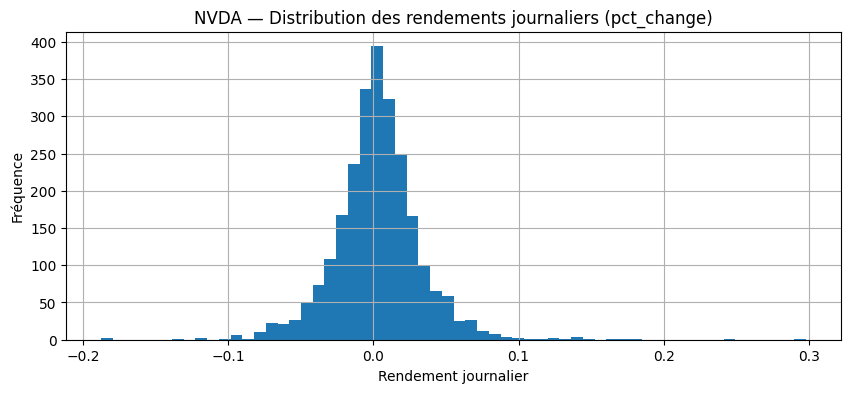

In [ ]:
# Rendements simples
ret = nvda_data_2.sort_values("Date")["Close_NVDA"].pct_change().dropna()

plt.figure(figsize=(10, 4))
plt.hist(ret, bins=60)
plt.title("NVDA — Distribution des rendements journaliers (pct_change)")
plt.xlabel("Rendement journalier")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

Le graphique montre une distribution **très concentrée autour de 0** (la plupart des rendements journaliers sont “petits”), mais avec des **queues** visibles : quelques jours présentent des variations nettement plus fortes (événements, annonces, journées de stress, etc.). Ce type de forme (pic central + observations extrêmes) est classique sur des rendements financiers.

La **skewness** mesurée vaut **≈ 0,63**. Une skewness **positive** signifie que la distribution est **asymétrique vers la droite** : il y a relativement plus de “poids” dans la **queue des rendements positifs**, donc des épisodes de hausses extrêmes un peu plus fréquents (ou plus marqués) que les épisodes de baisses extrêmes.

La **skewness** et la distribution des rendements se rejoignent puisqu'on voit que le graphique penche plus à droite qu'à gauche. 

En pratique, cela suggère que les rendements ne sont pas parfaitement symétriques, et que l’on doit s’attendre à quelques journées “exceptionnelles” (souvent celles qui s’accompagnent aussi de volumes anormalement élevés), ce qui motive ensuite l’utilisation de variables liées à l’amplitude des mouvements (ex. |ret|, volatilité, indicateurs de régime).


**Pourquoi calculer sur les rendements plutôt que sur les prix ?** Les prix sont non stationnaires et dominés par une tendance de long terme, ce qui rend leur distribution peu interprétable. Les **rendements** (variations relatives) sont l’objet standard en finance : ils permettent de comparer les mouvements dans le temps et entre actifs, et décrivent directement le risque (variabilité, asymétrie, extrêmes).

### A.2.2 - `nvda_data_2`

#### A.2.1.1 - `nvda_data_2` : Nettoyage
 On commence par l’identification et le traitement des valeurs manquantes.

In [51]:
#Diagnostic des valeurs manquantes
na_counts = nvda_data_2.isna().sum().sort_values(ascending=False)
print("Top colonnes avec NA (si > 0) :")
print(na_counts[na_counts > 0].head(15))
print("Top colonnes sans NA :")
print(na_counts[na_counts == 0].head(15))

Top colonnes avec NA (si > 0) :
ret_NVDA        1
ret_log_NVDA    1
dtype: int64
Top colonnes sans NA :
Low_QQQ        0
DGS10          0
VIXCLS         0
Volume_SPY     0
Volume_SOXX    0
Volume_QQQ     0
Open_SPY       0
Open_SOXX      0
Open_QQQ       0
Low_SPY        0
Low_SOXX       0
Date           0
Close_NVDA     0
High_SOXX      0
High_QQQ       0
dtype: int64


**Interprétation** : pas beaucoup de valeurs manquantes. C’est cohérent avec les séries issues de Yahoo Finance, généralement complètes sur les jours de cotation. 

In [52]:
#drop des valeurs NA
nvda_data_2 = nvda_data_2.dropna()

In [53]:
dup_dates = nvda_data_2["Date"].duplicated().sum()
print("\nNombre de dates dupliquées:", dup_dates)

#Si doublons : on garde la dernière occurrence (par convention)
if dup_dates > 0:
    nvda_data_2 = nvda_data_2.drop_duplicates(subset=["Date"], keep="last").reset_index(drop=True)


Nombre de dates dupliquées: 0


Aucun doublon de date n’est détecté : la base est donc cohérente sur la dimension temporelle et peut être utilisée telle quelle pour la suite. 

#### A.2.1.2 - `nvda_data_2` : Analyse rapide

In [54]:
desc_full = nvda_data_2.describe().T
desc_full.head(15)

,count,mean,min,25%,50%,75%,max,std
Date,2514,2019-12-31 19:02:43.245823232,2015-01-05 00:00:00,2017-07-03 12:00:00,2020-01-01 00:00:00,2022-06-29 18:00:00,2024-12-30 00:00:00,NaN
Close_NVDA,2514.0,20.747492,0.459257,3.54746,6.481875,21.215969,148.829041,32.241737
Dividends_NVDA,2514.0,0.000066,0.0,0.0,0.0,0.0,0.01,0.000563
High_NVDA,2514.0,21.124278,0.467895,3.595665,6.539179,21.722004,152.837669,32.841141
Low_NVDA,2514.0,20.335867,0.454458,3.451143,6.337561,20.784693,146.209926,31.600793
Open_NVDA,2514.0,20.748454,0.463576,3.516126,6.440165,21.147593,149.298887,32.273978
Stock Splits_NVDA,2514.0,0.005569,0.0,0.0,0.0,0.0,10.0,0.214776
Volume_NVDA,2514.0,467896503.221957,52448000.0,306270975.0,415169500.0,564191000.0,3692928000.0,253533239.721653
Close_QQQ,2514.0,236.751973,89.586868,133.256332,195.491631,327.2724,534.592407,117.778648
Close_SOXX,2514.0,95.661792,22.689617,44.928862,72.810768,140.081348,262.575653,61.52957


On commence par un `describe()` (transposé) pour obtenir, variable par variable, un **résumé rapide** :  
`count` (nb d’observations), `mean`, `std` (dispersion), `min`, quartiles (25% / 50% / 75%) et `max`.  
C’est un **contrôle qualité** utile avant d’aller plus loin. 

**Ce qu’on observe ici :**

- **Cohérence du merge** : la plupart des variables ont `count = 2514`, ce qui indique qu’on dispose d’un nombre d’observations similaire partout (pas de “trous” massifs après fusion).  
  La période couverte va de **2015-01-05** à **2024-12-30**.

- **Prix NVDA (colonnes Open/High/Low/Close)** : les ordres de grandeur sont cohérents avec une action ayant fortement monté sur la période.  

- **Dividendes / splits** :  
  - `Dividends_NVDA` est **quasi toujours à 0** (médiane = 0), ce qui est normal : les dividendes sont rares et ponctuels.  
  - `Stock Splits_NVDA` a un **max à 10**, ce qui reflète un split (événement exceptionnel), la plupart du temps la valeur est 0.

- **Volume NVDA** : très grande dispersion (écart-type élevé), avec un **minimum ~ 52M** et un **maximum ~ 3.7B**.  
  Ce type d’échelle est typique du volume : distribution très étalée, souvent asymétrique, ce qui pourra motiver ensuite des transformations (ex. log-volume) selon les besoins de la modélisation.

- **ETFs (SPY / QQQ / SOXX)** : les statistiques de `Close_*` montrent des niveaux et une dispersion cohérents avec des indices/ETFs de marché.  
  Ils serviront surtout à capturer le **contexte marché / tech / semi-conducteurs** dans la suite.

> Remarque : la ligne `Date` n’est pas vraiment interprétable via `mean/std` (ce sont des objets temporels). On retient surtout `min/max` pour la période d’étude.


In [55]:
max_close = nvda_data_2["Close_NVDA"].max() 
min_close = nvda_data_2["Close_NVDA"].min()
date_max = nvda_data_2.loc[nvda_data_2["Close_NVDA"].idxmax(), "Date"]
date_min = nvda_data_2.loc[nvda_data_2["Close_NVDA"].idxmin(), "Date"]
print("Le prix de cloture minimal est :", min_close, "le :", date_min)
print("Le prix de cloture maximal est :", max_close, "le :", date_max)

Le prix de cloture minimal est : 0.45925670862197876 le : 2015-01-07 00:00:00
Le prix de cloture maximal est : 148.82904052734375 le : 2024-11-07 00:00:00


À partir du dataset, on repère les extrêmes du prix de clôture (ajusté) sur la période :

- **Minimum** : 0,4593 le **2015-01-07**
- **Maximum** : 148,8290 le **2024-11-07**

Ainsi, sur l’intervalle étudié, le prix de NVDA a donc été multiplié par environ  324. 
Ce qui met en évidence une **tendance de long terme très marquée**. Dans la suite, cela motive le fait de travailler plutôt sur des variables plus comparables dans le temps (par exemple des **rendements**) que sur les niveaux de prix, car les prix sont fortement non stationnaires.

---
# Conclusion de la partie A — Données

Cette partie a permis de **récupérer**, **structurer** et **mettre au propre** l’ensemble des données nécessaires au projet. On dispose désormais d’un jeu de données cohérent dans le temps, reproductible (grâce à la sauvegarde en local), et prêt pour l’analyse descriptive puis la modélisation.

À ce stade, les fichiers/datasets suivants sont disponibles :

- `nvda_data_2` : **dataset principal fusionné et nettoyé** (NVDA + ETFs + FRED), aligné sur les dates de cotation de NVDA. C’est la base utilisée pour toute la suite (EDA, création des variables, prédiction).
- `nvda_stock_data_clean` : **données NVDA nettoyées** (version “clean” des données Yahoo Finance).
- `etf_stock_data_clean` : **données ETFs nettoyées** (SPY / QQQ / SOXX).
- `fred_stock_data_clean` : **données FRED nettoyées** (VIXCLS, DGS10).

La partie suivante peut donc se concentrer sur le **contrôle qualité de la base finale** et la **construction de variables** pertinentes pour expliquer et prédire le volume.


---
# B. Visualisation des données

Dans cette partie, on réalise une visualisation des données à partir de la base principale `nvda_data_2`, qui regroupe les données **NVDA**, les **ETFs** (SPY/QQQ/SOXX) et les indicateurs **FRED** (VIX, taux US 10 ans).

L’objectif est de **mieux comprendre les données avant de modéliser**. Concrètement, on cherche à :
- décrire les grandes tendances sur le **prix** et le **volume** de NVDA,
- repérer des épisodes marquants (pics de volatilité, mouvements extrêmes, drawdowns),
- et replacer ces épisodes dans leur **contexte marché / secteur / macro-financier** grâce aux variables externes (ETFs, VIX, taux).

Cette étape sert donc à la fois de **contrôle qualité** (vérifier que les séries se comportent comme attendu) et de **base de motivation** pour les variables qui seront construites ensuite (rendements, volatilité, indicateurs de régime, retards, etc.).


---
## B.1 — Préparation des variables descriptives

Avant de tracer des graphiques, on prépare un ensemble de variables descriptives qui permettent de lire correctement des séries financières. L’idée générale est la suivante : **les niveaux de prix** sont difficiles à comparer dans le temps (tendance forte, changements d’échelle), tandis que des **transformations standard** (rendements, volatilité, drawdown…) donnent une lecture plus stable et plus interprétable.

### 1) Base de travail : NVDA-only
On part de `nvda_data_2` (dataset complet) et on construit une sous-base `nvda_data` qui ne contient que les colonnes NVDA.  
Cela simplifie les graphiques centrés sur NVIDIA (prix, volume, rendements), tout en gardant `nvda_data_2` disponible pour les comparaisons avec le marché/secteur et la macro.

> **Remarque** : `nvda_data` est reconstruit à partir de `nvda_data_2` afin de conserver une source unique cohérente (mêmes dates, mêmes conventions de noms `*_NVDA`) et d’éviter d’utiliser `nvda_stock_data_clean`, qui correspond à une version antérieure du projet (NVDA seul) et peut introduire des incohérences.

### 2) Indicateurs calculés sur NVDA (variables “standards”)
On calcule ensuite des indicateurs classiques :

On note $$ P_t $$ le prix à date t
- **Rendement journalier** `ret_NVDA`
  $$ ret_t = \frac{P_t - P_{t-1}}{P_{t-1}} $$

  On travaille sur les **variations relatives** plutôt que sur le niveau du prix. Cela permet de comparer des périodes où le prix n’est pas du tout à la même échelle, et de repérer plus facilement les journées “exceptionnelles”.

- **Moyennes mobiles (20 / 50 / 200 jours)**  
  Une moyenne mobile est un lissage du prix :
  $$ MA_k(t) = \frac{1}{k}\sum_{j=0}^{k-1} P_{t-j} $$
  Elle sert à visualiser la tendance à différentes échelles :
  - 20 jours ≈ horizon court (≈ 1 mois boursier),
  - 50 jours ≈ horizon intermédiaire,
  - 200 jours ≈ horizon long (≈ 1 an boursier).
  On ne les utilise pas ici comme “signal de trading”, mais comme **outil de lecture** des tendances et des ruptures.

- **Volatilité réalisée** `vol20`  
  On calcule l’écart-type glissant des rendements sur 20 jours :
  $$ vol20_t = sd(ret_{t-19}, \dots, ret_t) $$
  Cela permet d’identifier des **changements de régime** (marché calme vs période agitée). La volatilité est particulièrement intéressante dans un projet sur le **volume**, car les épisodes de forte volatilité s’accompagnent souvent de volumes anormalement élevés.

- **Performance cumulée** `cumret_NVDA` et **drawdown** `drawdown_NVDA`  
  La performance cumulée permet de suivre la croissance d’un investissement “buy-and-hold” :
  $$ cumret_t = \prod_{s\le t} (1+ret_s) $$
  Le drawdown mesure, à chaque date, la perte par rapport au maximum historique atteint :
  $$ drawdown_t = \frac{cumret_t}{\max_{u\le t} cumret_u} - 1 $$
  Ces deux indicateurs servent à repérer des épisodes de baisse marquée et à décrire la dynamique de récupération (retour vers les plus hauts).

### 3) Variables de contexte (marché/secteur & macro)
En parallèle, on prépare des variables de contexte pour éviter une lecture “NVDA en vase clos” :
- **Rendements des ETFs** (SPY/QQQ/SOXX) : permettent de comparer NVDA à
  - une tendance **marché** (SPY),
  - une tendance **tech** (QQQ),
  - une tendance **sectorielle semi-conducteurs** (SOXX).
- **Variations sur FRED** : plutôt que les niveaux, on regarde des changements de régime via des variations, par exemple :
  - \(\Delta VIX\) (stress qui monte/baisse),
  - \(\Delta\) taux 10 ans (durcissement / assouplissement des conditions financières).

L’objectif est de pouvoir répondre à une question simple pendant l’EDA :
> lorsque NVDA bouge (prix, volatilité, volume), est-ce surtout un effet **spécifique à NVDA**, ou est-ce cohérent avec un mouvement **global du marché**, **tech** ou **sectoriel**, et/ou un changement de **régime macro-financier** ?


In [18]:
#Sécurisation (Date + tri)
nvda_data_2["Date"] = pd.to_datetime(nvda_data_2["Date"])
nvda_data_2 = nvda_data_2.sort_values("Date").reset_index(drop=True)

#Vérification minimale
required = {"Date", "Close_NVDA", "Volume_NVDA"}
missing = required - set(nvda_data_2.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans nvda_data_2 : {missing}")

#on copie une sous bdd pour ne pas toucher à la bdd principale 
#sert pour les graphiques uniqument centrés autour du cours de NVIDIA
nvda_data = nvda_data_2[["Date", "Open_NVDA", "High_NVDA", "Low_NVDA", "Close_NVDA", "Volume_NVDA"]].copy()

Indicateurs relatifs à NVIDIA :

In [59]:
# Conversion explicite en numérique (robuste)
num_cols = ["Open_NVDA", "High_NVDA", "Low_NVDA", "Close_NVDA", "Volume_NVDA"]

for c in num_cols:
    if c in nvda_data.columns:
        s = nvda_data[c].astype(str).str.replace(",", ".", regex=False)
        s = s.replace({"None": np.nan, "nan": np.nan, "NaN": np.nan, "": np.nan})
        nvda_data[c] = pd.to_numeric(s, errors="coerce")

# Indicateurs NVDA (EDA)
nvda_data["ret_NVDA"] = nvda_data["Close_NVDA"].pct_change()

nvda_data["MA20"]  = nvda_data["Close_NVDA"].rolling(20).mean()
nvda_data["MA50"]  = nvda_data["Close_NVDA"].rolling(50).mean()
nvda_data["MA200"] = nvda_data["Close_NVDA"].rolling(200).mean()

nvda_data["vol20"] = nvda_data["ret_NVDA"].rolling(20).std()  # volatilité réalisée (non annualisée)

# Indice de richesse + performance cumulée + drawdown (standard)
nvda_data["wealth_NVDA"] = (1 + nvda_data["ret_NVDA"]).cumprod()
nvda_data["cumret_NVDA"] = nvda_data["wealth_NVDA"] - 1
nvda_data["drawdown_NVDA"] = nvda_data["wealth_NVDA"] / nvda_data["wealth_NVDA"].cummax() - 1

#affichage de controle 
nvda_data.head()

,Date,Close_NVDA,Dividends_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Stock Splits_NVDA,Volume_NVDA,ret_NVDA,MA20,MA50,MA200,vol20,wealth_NVDA,cumret_NVDA,drawdown_NVDA
0,2015-01-02,0.483011,0.0,0.486611,0.475333,0.483011,0.0,113680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,0.474853,0.0,0.484451,0.472694,0.483011,0.0,197952000,-0.016890,NaN,NaN,NaN,NaN,0.983110,-0.016890,0.000000
2,2015-01-06,0.460456,0.0,0.476053,0.459977,0.475573,0.0,197764000,-0.030318,NaN,NaN,NaN,NaN,0.953303,-0.046697,-0.030318
3,2015-01-07,0.459257,0.0,0.467895,0.457817,0.463816,0.0,321808000,-0.002606,NaN,NaN,NaN,NaN,0.950819,-0.049181,-0.032845
4,2015-01-08,0.476533,0.0,0.479412,0.464296,0.464536,0.0,283780000,0.037618,NaN,NaN,NaN,NaN,0.986587,-0.013413,0.000000


Indicateurs relatifs au contexte (ETFs + FRED) :

**Remarque** : nous ne construisons pas ces variables de contexte directement dans la partie A pour laisser aussi plus de liberté pour tester différentes transformations et sélections de variables selon les analyses menées ensuite.

In [58]:
context_cols = ["Close_SPY", "Close_QQQ", "Close_SOXX", "VIXCLS", "DGS10"]
available_context = [c for c in context_cols if c in nvda_data_2.columns]

context_data = nvda_data_2[["Date"] + available_context].copy()
context_data["Date"] = pd.to_datetime(context_data["Date"], errors="coerce")
context_data = context_data.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Retours ETFs
for c in ["Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if c in context_data.columns:
        context_data[f"ret_{c.split('_')[1]}"] = context_data[c].pct_change()

# Variations de régime (FRED)
if "VIXCLS" in context_data.columns:
    context_data["VIXCLS"] = pd.to_numeric(context_data["VIXCLS"], errors="coerce")
    context_data["dVIX"] = context_data["VIXCLS"].diff()

if "DGS10" in context_data.columns:
    context_data["DGS10"] = pd.to_numeric(context_data["DGS10"], errors="coerce")
    context_data["dDGS10"] = context_data["DGS10"].diff()

# Affichage de contrôle
context_data.head()


,Date,Close_SPY,Close_QQQ,Close_SOXX,VIXCLS,DGS10,ret_SPY,ret_QQQ,ret_SOXX,dVIX,dDGS10
0,2015-01-05,167.508835,93.394058,27.039425,19.92,2.04,NaN,NaN,NaN,NaN,NaN
1,2015-01-06,165.931015,92.141808,26.436634,21.12,1.97,-0.009419,-0.013408,-0.022293,1.20,-0.07
2,2015-01-07,167.998749,93.329590,26.697943,19.31,1.96,0.012461,0.012891,0.009884,-1.81,-0.01
3,2015-01-08,170.979874,95.115921,27.490770,17.01,2.03,0.017745,0.019140,0.029696,-2.30,0.07
4,2015-01-09,169.609741,94.489799,27.505617,17.55,1.98,-0.008013,-0.006583,0.000540,0.54,-0.05


**Bilan partie** : À ce stade, on dispose :

- d’une base **NVDA-only** (`nvda_data`) construite à partir de `nvda_data_2` et enrichie avec les principaux indicateurs utilisés en analyse descriptive :
  - rendements journaliers (`ret_NVDA`),
  - moyennes mobiles (20/50/200 jours),
  - volatilité réalisée à 20 jours (`vol20`),
  - performance cumulée (`cumret_NVDA`) et drawdown (`drawdown_NVDA`).

- d’un jeu de **variables de contexte** (`context_data`) dérivées de `nvda_data_2`, permettant de replacer NVDA dans son environnement :
  - rendements des ETFs (SPY / QQQ / SOXX),
  - variations de régime macro-financier via FRED (\(\Delta VIX\), \(\Delta\) taux US 10 ans).

Ces éléments forment le **socle** des visualisations et des analyses descriptives menées dans les sections suivantes : on pourra à la fois décrire NVDA “en interne” (prix/volume/risque) et comparer ses épisodes marquants aux mouvements du marché, du secteur et du régime macro.


---
## B.2 — Prix de NVDA et tendances (moyennes mobiles)

On commence l’analyse descriptive par l’évolution du **prix de clôture (ajusté)** de NVDA. Ce graphique donne une lecture immédiate des grandes phases du titre (accélérations, corrections, périodes plus stables). Pour rendre cette dynamique plus lisible, on superpose des **moyennes mobiles** (20, 50 et 200 jours) qui lissent les fluctuations quotidiennes et permettent de repérer des tendances de **court**, **moyen** et **long** terme, ainsi que d’éventuels changements de régime.



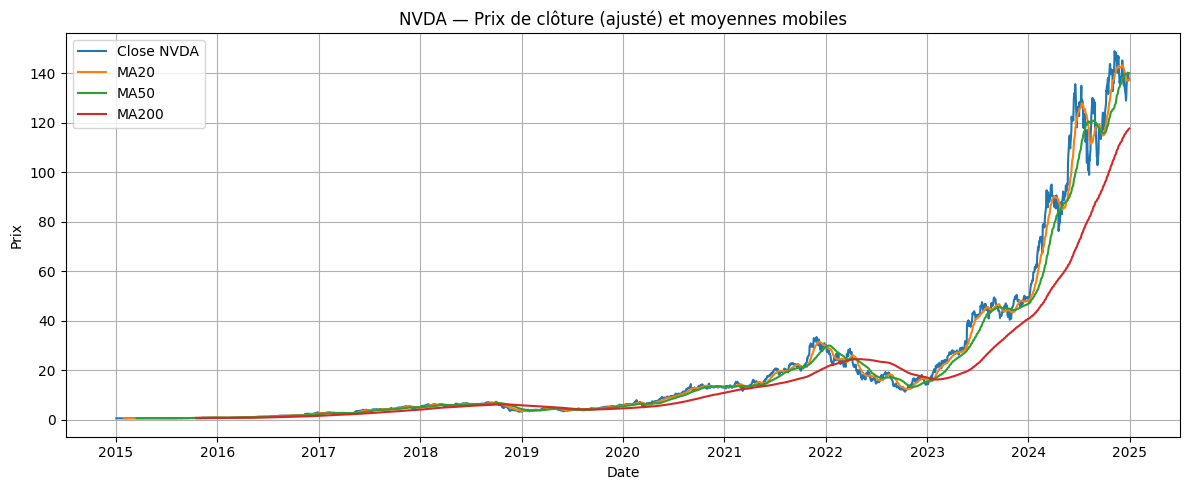

In [60]:
plt.figure(figsize=(12, 5))
plt.plot(nvda_data["Date"], nvda_data["Close_NVDA"], label="Close NVDA")

#On trace les MAs uniquement si elles existent
for col, lab in [("MA20", "MA20"), ("MA50", "MA50"), ("MA200", "MA200")]:
    if col in nvda_data.columns:
        plt.plot(nvda_data["Date"], nvda_data[col], label=lab)

plt.title("NVDA — Prix de clôture (ajusté) et moyennes mobiles")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Interprétation** : Le graphique met en évidence une tendance haussière de long terme sur la période, avec une accélération marquée à partir de 2023–2024. 

Les moyennes mobiles jouent ici un rôle de lissage : 

- **MA20** et **MA50** suivent la dynamique de court/moyen terme (et réagissent rapidement aux phases de correction), 
- tandis que **MA200** capture la tendance structurelle. 

On observe des épisodes de repli (notamment autour de 2018–2019 et surtout en 2022), puis un retour en régime haussier lorsque le prix repasse durablement au-dessus des moyennes longues. 

---
## B.3 — Rendements et volatilité réalisée

Après les niveaux de prix, on passe à des variables plus adaptées à l’analyse financière : les **rendements journaliers** (variations relatives) et une mesure simple de **volatilité réalisée** (écart-type glissant sur 20 jours).  
Ces deux séries permettent de repérer rapidement les **périodes calmes** versus les **épisodes de stress** (queues, pics de volatilité), et servent de base pour interpréter ensuite les mouvements du volume. Elles motivent aussi l’utilisation de variables de contexte (marché, secteur, VIX, taux) pour distinguer ce qui relève d’un choc global de ce qui est plus spécifique à NVDA.


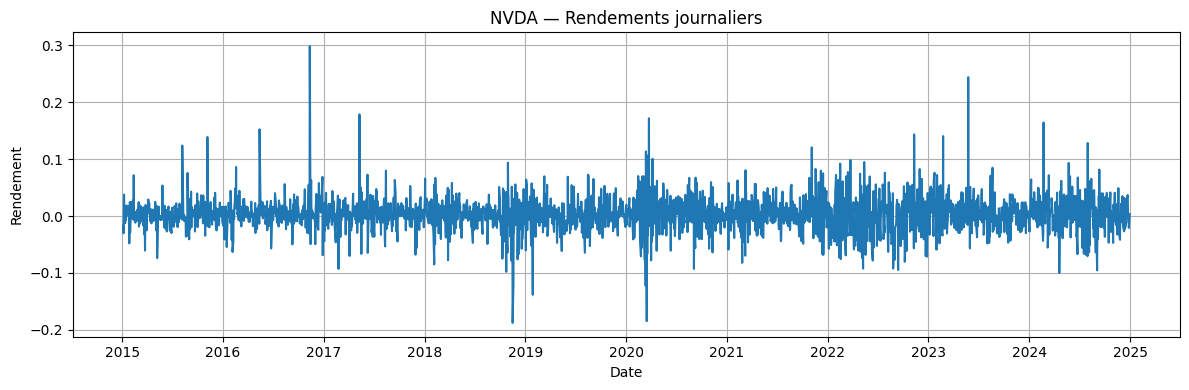

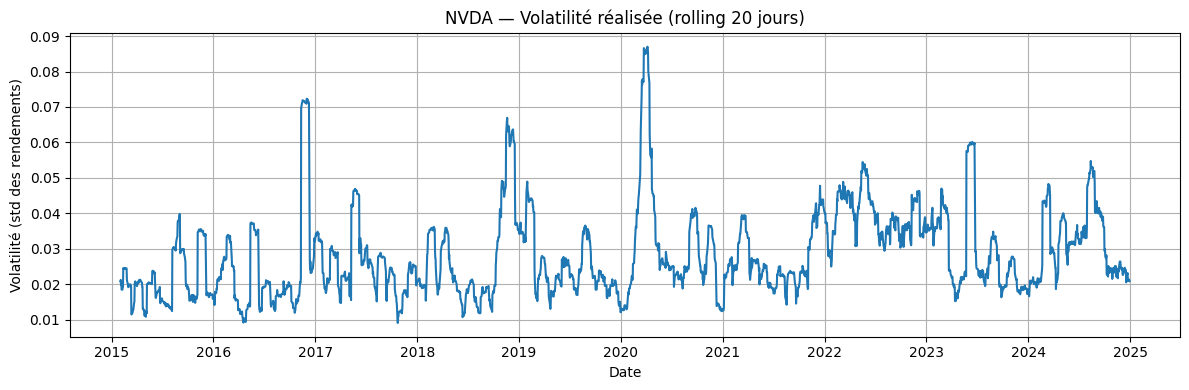

In [22]:
#Rendements
plt.figure(figsize=(12, 4))
plt.plot(nvda_data["Date"], nvda_data["ret_NVDA"])
plt.title("NVDA — Rendements journaliers")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.tight_layout()
plt.grid()
plt.show()

#Volatilité réalisée (20 jours)
if "vol20" in nvda_data.columns:
    plot_vol = nvda_data.dropna(subset=["Date", "vol20"]).copy()
    plt.figure(figsize=(12, 4))
    plt.plot(plot_vol["Date"], plot_vol["vol20"])
    plt.title("NVDA — Volatilité réalisée (rolling 20 jours)")
    plt.xlabel("Date")
    plt.ylabel("Volatilité (std des rendements)")
    plt.tight_layout()
    plt.grid()
    plt.show()

**Interprétation.** Les rendements journaliers de NVDA sont globalement **centrés autour de zéro**, mais ils présentent des **pics ponctuels** (à la hausse comme à la baisse). Cela signifie que, même si la plupart des journées enregistrent des variations modestes, certaines dates concentrent des mouvements beaucoup plus importants (annonces, chocs de marché, changements de sentiment).

La volatilité réalisée (écart-type glissant sur 20 jours) met en évidence une dynamique en **régimes** :
- des phases relativement calmes alternent avec des phases de stress où la dispersion des rendements augmente nettement ;
- on observe notamment des montées de volatilité sur **2016–2017**, **2018–2019**, et un **pic très marqué en 2020** ;
- puis, à partir de **2022–2024**, des épisodes globalement plus modérés mais parfois **persistants**, suggérant un environnement moins stable qu’en période “calme”.

Cette structure est importante pour la suite : elle justifie (i) l’utilisation de **variables glissantes** (volatilité, moyennes mobiles, lags) et (ii) l’introduction de **variables de contexte** (marché/secteur, VIX, taux) pour distinguer ce qui relève d’un choc global de ce qui est spécifique à NVDA. Autrement dit, le comportement de NVDA **n’est pas constant dans le temps**, et l’analyse/modélisation doit en tenir compte.


---
## B.4 — Mise en contexte : marché, secteur et régime de risque

Jusqu’ici, l’analyse se concentrait sur NVDA “en interne” (prix, rendements, volatilité). On élargit maintenant la perspective grâce aux variables de contexte présentes dans `nvda_data_2` :  
- les ETFs **SPY / QQQ / SOXX** pour représenter respectivement le **marché global**, la composante **tech**, et le **secteur des semi-conducteurs** ;  
- les séries FRED (**VIX** et **taux US 10 ans**) pour capturer un **régime de risque** et des **conditions financières**.

L’objectif est de comparer les épisodes marquants observés sur NVDA à ceux de son environnement, afin de séparer :
- ce qui s’explique par des facteurs **systématiques** (marché/secteur),
- et ce qui semble plus **idiosyncratique** (spécifique à NVDA).

Cette mise en contexte est essentielle pour interpréter correctement les mouvements extrêmes et, plus tard, pour construire des variables explicatives pertinentes pour la prédiction du volume.


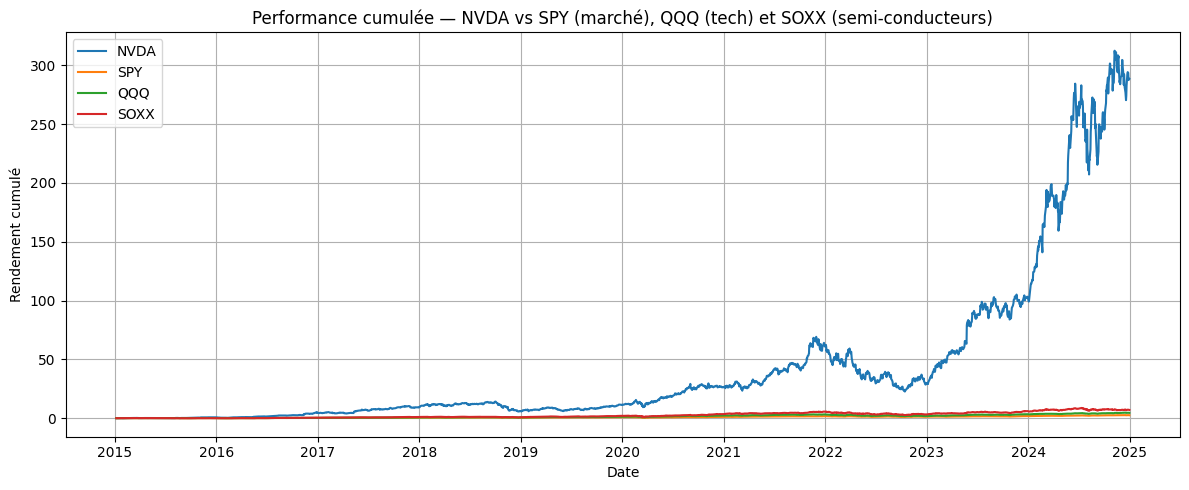

In [63]:
# Table dédiée comparaison (sans modifier nvda_data_2)
cols = ["Date", "Close_NVDA", "Close_SPY", "Close_QQQ", "Close_SOXX"]
cols = [c for c in cols if c in nvda_data_2.columns]

df_cmp = nvda_data_2[cols].copy()
df_cmp["Date"] = pd.to_datetime(df_cmp["Date"], errors="coerce")
df_cmp = df_cmp.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Conversion numérique
for c in cols:
    if c != "Date":
        df_cmp[c] = pd.to_numeric(df_cmp[c], errors="coerce")

# Rendements simples (colonne par colonne)
df_ret = df_cmp.set_index("Date").pct_change()

# Performance cumulée (wealth index - 1)
cum_perf = (1 + df_ret).cumprod() - 1

plt.figure(figsize=(12, 5))
for c in cum_perf.columns:
    plt.plot(cum_perf.index, cum_perf[c], label=c.replace("Close_", ""))

plt.title("Performance cumulée — NVDA vs SPY (marché), QQQ (tech) et SOXX (semi-conducteurs)")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interprétation** :
1) **NVDA domine très largement les références**
La courbe NVDA s’envole sur la période, avec une performance cumulée qui devient *sans commune mesure* avec SPY/QQQ/SOXX (les ETFs restent proches de zéro à cette échelle). Cela indique que, sur le long terme, la dynamique de NVDA ne peut pas être expliquée uniquement par un “effet marché” ou “effet secteur” : il existe une composante **fortement idiosyncratique** (spécifique à NVDA).

2) **Mais les grands épisodes de baisse semblent partager un calendrier commun**
Même si les courbes des ETFs sont visuellement écrasées par l’échelle, on distingue des phases où NVDA corrige nettement (ex. autour de 2018–2019, 2022). Ces périodes correspondent typiquement à des phases de stress ou de correction plus larges, ce qui suggère que NVDA reste exposée à des facteurs **systématiques** (marché/tech/secteur), même si sa trajectoire de long terme est beaucoup plus extrême.

**Conclusion pour la suite** Ce graphique valide l’intérêt d’introduire des variables de contexte (SPY/QQQ/SOXX, VIX, taux) : elles servent à capter les composantes **systématiques**. Mais il montre aussi que NVDA a une dynamique propre très marquée : pour comprendre (et prédire) le **volume**, il faudra aussi tenir compte de signaux plus spécifiques à NVDA et des épisodes de stress/accélération identifiés dans les sections suivantes.

**Limite de lecture (échelle)**
Comme NVDA surperforme énormément, l’échelle du graphique rend les écarts entre SPY/QQQ/SOXX difficiles à lire. Pour mieux comparer “marché vs tech vs semi”, on pourra va refaire un graphique plus lisible. 

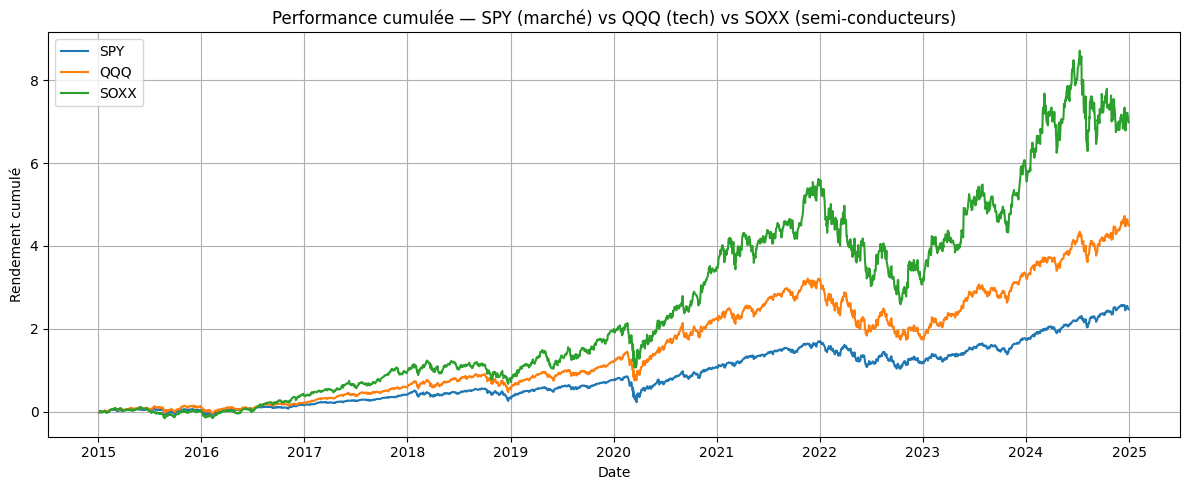

In [ ]:
cols = ["Date", "Close_SPY", "Close_QQQ", "Close_SOXX"]
cols = [c for c in cols if c in nvda_data_2.columns]

df = nvda_data_2[cols].copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Conversion numérique + rendements + performance cumulée
prices = df.set_index("Date").apply(pd.to_numeric, errors="coerce")
rets = prices.pct_change()
cum_perf = (1 + rets).cumprod() - 1

plt.figure(figsize=(12, 5))
for c in cum_perf.columns:
    plt.plot(cum_perf.index, cum_perf[c], label=c.replace("Close_", ""))

plt.title("Performance cumulée — SPY (marché) vs QQQ (tech) vs SOXX (semi-conducteurs)")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Premier graphique comparant SPY, QQQ et SOXX sans NVIDIA. 

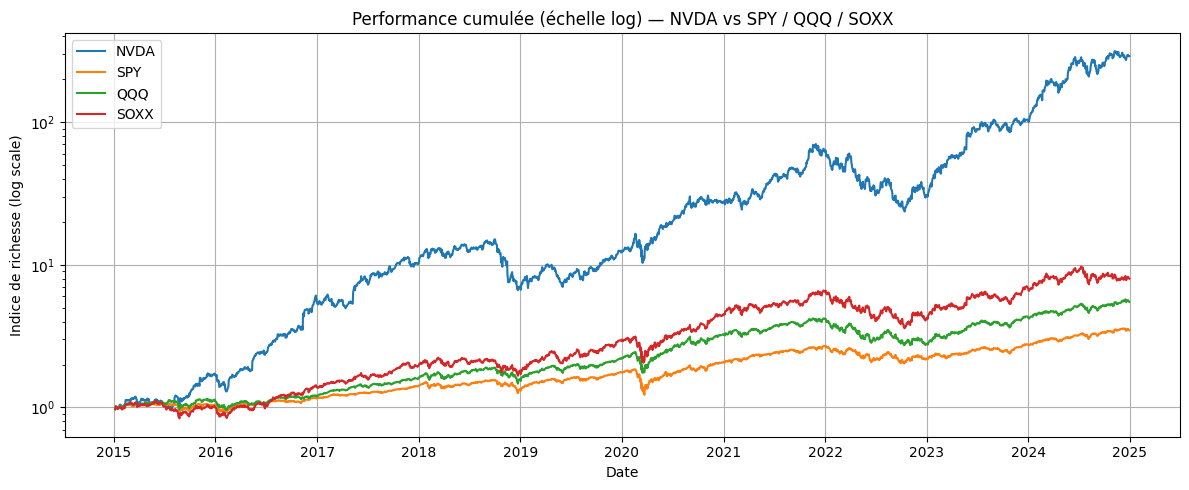

In [ ]:
cols = ["Date", "Close_NVDA", "Close_SPY", "Close_QQQ", "Close_SOXX"]
cols = [c for c in cols if c in nvda_data_2.columns]

df = nvda_data_2[cols].copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

prices = df.set_index("Date").apply(pd.to_numeric, errors="coerce")
rets = prices.pct_change()
cum_perf = (1 + rets).cumprod()  # wealth index

plt.figure(figsize=(12, 5))
for c in cum_perf.columns:
    plt.plot(cum_perf.index, cum_perf[c], label=c.replace("Close_", ""))

plt.yscale("log")
plt.title("Performance cumulée (échelle log) — NVDA vs SPY / QQQ / SOXX")
plt.xlabel("Date")
plt.ylabel("Indice de richesse (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Sur ce graphique en **échelle logarithmique**, on compare plus facilement les trajectoires.

---

## B.5 — Distribution des rendements et épisodes extrêmes

Après les séries temporelles (prix, rendements, volatilité), on se concentre sur les **épisodes extrêmes** : ceux qui sortent du “comportement moyen” et qui sont souvent les plus informatifs pour comprendre le volume.

On complète donc l’EDA avec trois angles :
1) la **distribution des rendements journaliers** pour visualiser la dispersion, l’asymétrie et la présence éventuelle de valeurs extrêmes (queues),
2) le **drawdown** (perte relative depuis un sommet) pour repérer les périodes de stress et mesurer l’ampleur des corrections,
3) une relation simple entre **amplitude des rendements** (par exemple \(|ret|\)) et **volume**, afin de vérifier si les jours de gros mouvements s’accompagnent de pics d’activité.

L’objectif est de caractériser la présence de **queues épaisses**, d’identifier des **régimes de stress**, et de relier ces épisodes à la dynamique du volume, ce qui prépare directement la partie modélisation.



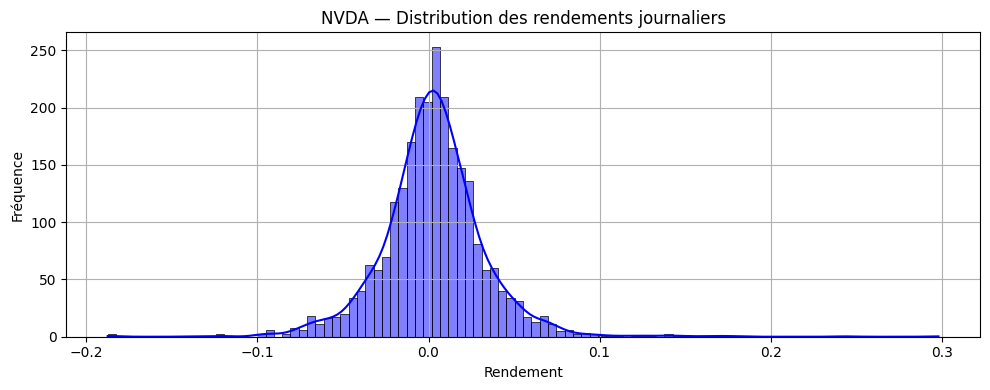

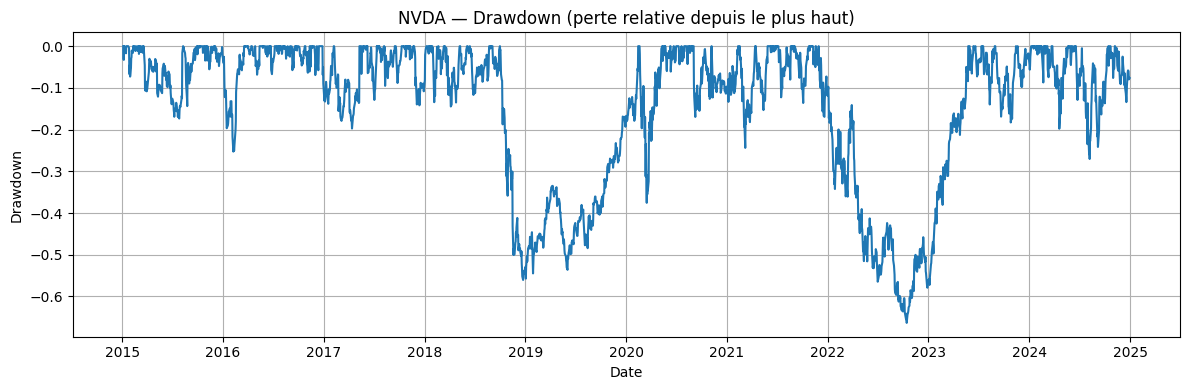

In [68]:
# Histogramme des rendements
df_r = nvda_data.dropna(subset=["ret_NVDA"]).copy()

plt.figure(figsize=(10, 4))
#avec seaborn c'est plus joli que plt
sns.histplot(df_r['ret_NVDA'], bins=100, kde=True, color='blue')
plt.title("NVDA — Distribution des rendements journaliers")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.grid()
plt.show()

# Drawdown
df_dd = nvda_data.dropna(subset=["drawdown_NVDA"]).copy()

plt.figure(figsize=(12, 4))
plt.plot(df_dd["Date"], df_dd["drawdown_NVDA"])
plt.title("NVDA — Drawdown (perte relative depuis le plus haut)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.tight_layout()
plt.grid()
plt.show()


**Interprétation.** 
Le premier graphique a déjà été interprété. 

Le graphique de **drawdown** met en évidence plusieurs épisodes de pertes importantes par rapport au dernier plus haut. On observe des phases de correction marquées autour de **2018–2019** et surtout **2022–2023**, suivies de périodes de récupération plus ou moins rapides. Le drawdown permet ici de visualiser non seulement l’ampleur des baisses, mais aussi la durée nécessaire pour revenir aux sommets précédents.

Ensemble, ces deux visualisations confirment que NVDA combine une dynamique de long terme très forte avec une exposition à des **chocs ponctuels** et à des **corrections profondes**. C’est précisément ce type de comportement (journées extrêmes, changements de régime) qui est susceptible d’être associé à des variations marquées du **volume**, ce qui motive la suite de l’analyse.

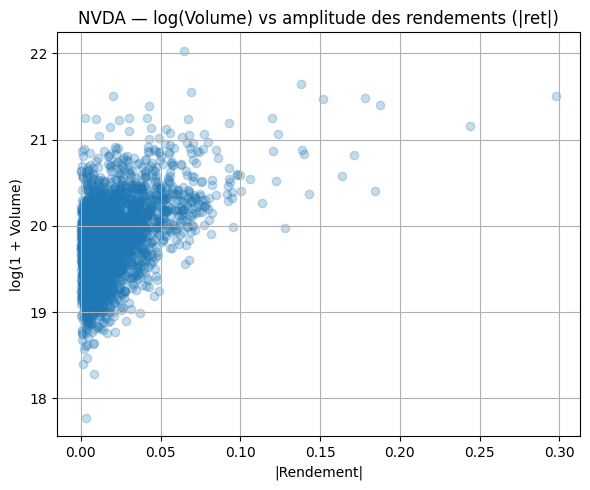

In [69]:
df_sc = nvda_data.dropna(subset=["ret_NVDA", "Volume_NVDA"]).copy()
df_sc["abs_ret"] = df_sc["ret_NVDA"].abs()
df_sc["log_vol"] = np.log1p(df_sc["Volume_NVDA"])  # log(1+V) pour éviter log(0)

plt.figure(figsize=(6, 5))
plt.scatter(df_sc["abs_ret"], df_sc["log_vol"], alpha=0.25)
plt.title("NVDA — log(Volume) vs amplitude des rendements (|ret|)")
plt.xlabel("|Rendement|")
plt.ylabel("log(1 + Volume)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Interprétation.** Le nuage de points suggère une relation globalement **positive** entre l’amplitude des mouvements de prix (\(|ret|\)) et le volume : lorsque NVDA connaît des variations journalières plus fortes, l’activité de marché tend à être plus élevée. Ce résultat est cohérent avec l’idée que les journées “informatives” (annonces, stress, changement de sentiment) attirent davantage de transactions.

Cependant, la dispersion reste importante : pour une même amplitude \(|ret|\), le volume peut varier fortement. Cela indique que \(|ret|\) n’explique qu’une partie de l’activité, et que le volume dépend aussi d’autres dimensions (régime de volatilité, contexte marché/secteur, événements spécifiques, inertie du volume via des lags, etc.), ce qui justifie l’introduction de variables de contexte et de caractéristiques supplémentaires dans la suite.


---

## B.6 — Corrélations ciblées (sur variations)

Une matrice de corrélations calculée directement sur toutes les colonnes brutes est souvent **peu informative** : elle mélange des variables de nature différente et, surtout, les **niveaux de prix** (non stationnaires) peuvent générer des corrélations artificiellement élevées simplement parce qu’ils suivent tous une tendance.

Pour obtenir une lecture plus pertinente, on calcule donc les corrélations sur des **transformations comparables** :
- les **rendements** pour NVDA et les ETFs (SPY/QQQ/SOXX),
- les **variations** des indicateurs macro-financiers (par exemple \(\Delta VIX\) et \(\Delta\) taux US 10 ans).

L’objectif est de mesurer des co-mouvements “réels” à court terme (jours où tout monte/baisse), plutôt que de corréler des tendances de long terme.


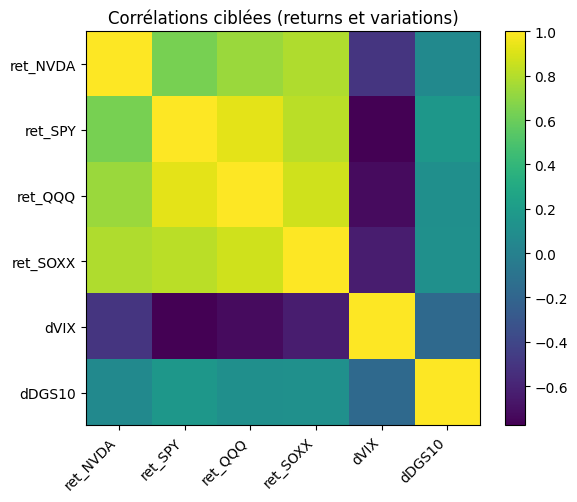

,ret_NVDA,ret_SPY,ret_QQQ,ret_SOXX,dVIX,dDGS10
ret_NVDA,1.000,0.636,0.731,0.790,-0.502,0.066
ret_SPY,0.636,1.000,0.929,0.815,-0.778,0.162
ret_QQQ,0.731,0.929,1.000,0.870,-0.724,0.105
ret_SOXX,0.790,0.815,0.870,1.000,-0.633,0.115
dVIX,-0.502,-0.778,-0.724,-0.633,1.000,-0.168
dDGS10,0.066,0.162,0.105,0.115,-0.168,1.000


In [70]:
corr_df = nvda_data_2[["Date"]].copy()
corr_df["Date"] = pd.to_datetime(corr_df["Date"], errors="coerce")
corr_df = corr_df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Returns NVDA + ETFs
for col in ["Close_NVDA", "Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if col in nvda_data_2.columns:
        s = pd.to_numeric(nvda_data_2[col], errors="coerce")
        corr_df[f"ret_{col.split('_')[1]}"] = s.pct_change()

# ΔVIX, ΔDGS10
if "VIXCLS" in nvda_data_2.columns:
    corr_df["dVIX"] = pd.to_numeric(nvda_data_2["VIXCLS"], errors="coerce").diff()
if "DGS10" in nvda_data_2.columns:
    corr_df["dDGS10"] = pd.to_numeric(nvda_data_2["DGS10"], errors="coerce").diff()

corr_matrix = corr_df.drop(columns=["Date"]).dropna().corr()

# Affichage lisible
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix.values)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Corrélations ciblées (returns et variations)")
plt.colorbar()
plt.tight_layout()
plt.show()

corr_matrix.round(3)



**Interprétation.** La matrice de corrélations met en évidence une composante “marché/secteur” importante dans les rendements de NVDA, tout en précisant **quel environnement explique le mieux ses co-mouvements**.

- La corrélation de `ret_NVDA` est particulièrement élevée avec `ret_SOXX` (≈ 0,79) et `ret_QQQ` (≈ 0,73). C’est cohérent : NVDA est à la fois une valeur **semi-conducteurs** et une valeur **tech**, et ses rendements évoluent souvent dans le même sens que ces deux univers.

- La corrélation avec `ret_SPY` est plus faible (≈ 0,64). Cela suggère que NVDA est davantage “pilotée” par des facteurs **sectoriels/tech** que par le marché agrégé pris dans son ensemble (même si l’exposition au marché reste forte).

- On observe aussi une relation négative entre les rendements actions et `dVIX` : lorsque le VIX augmente (montée de l’aversion au risque / stress de marché), les rendements ont tendance à être plus faibles. Ce signe est attendu et confirme que les épisodes de stress sont visibles dans les variations journalières.

- Enfin, `dDGS10` apparaît faiblement corrélé aux rendements à cette fréquence (journalière). Cela ne signifie pas que les taux n’ont aucun effet, mais plutôt que leur impact est **plus indirect**, potentiellement non linéaire, et/ou plus visible à d’autres horizons (ou via des épisodes spécifiques de politique monétaire).

Au total, ces corrélations justifient pleinement l’usage des variables de contexte : SPY/QQQ/SOXX captent une partie des mouvements de NVDA, tandis que `dVIX` renseigne sur le régime de risque associé aux journées de stress.

---
# Conclusion de la partie B - Visualisation des données

Cette analyse a permis de caractériser le comportement de NVDA sous plusieurs angles (prix, rendements, volatilité, épisodes extrêmes) et de le replacer dans son environnement (marché, tech, semi-conducteurs et régime de risque).

Les principaux enseignements sont les suivants :

1) **Dynamique de long terme et tendances.**  
Le prix de NVDA suit une tendance de fond très marquée, avec des phases d’accélération et de correction bien visibles. Les moyennes mobiles (20/50/200 jours) rendent ces changements de régime plus lisibles et confirment que la trajectoire n’est pas homogène dans le temps.

2) **Rendements et volatilité : alternance de régimes.**  
Les rendements journaliers sont centrés autour de zéro mais présentent des mouvements extrêmes ponctuels. La volatilité réalisée (20 jours) met en évidence des périodes de stress (pic net autour de 2020, épisodes marqués autour de 2018–2019 et 2022–2023), alternant avec des phases plus calmes. Cette instabilité temporelle motive l’utilisation d’indicateurs glissants et de variables de contexte.

3) **Épisodes extrêmes et drawdowns.**  
La distribution des rendements suggère des queues épaisses (événements extrêmes plus fréquents que dans une lecture “gaussienne”). Le drawdown confirme l’existence de corrections profondes, et permet de visualiser la dynamique de récupération après les phases de baisse.

4) **Contexte marché/secteur et régime de risque.**  
La comparaison des performances cumulées et la matrice de corrélations montrent que NVDA est fortement liée à son environnement **tech** et **semi-conducteurs** (QQQ, SOXX), tout en restant exposée au marché global (SPY). Les variations du VIX sont négativement liées aux rendements actions, ce qui confirme le rôle du régime de risque dans les périodes de stress. À l’inverse, les variations quotidiennes du taux 10 ans semblent moins directement corrélées sur la période.

5) **Lien avec le volume (motivation pour la modélisation).**  
Le nuage de points volume vs \(|ret|\) suggère que les journées de grands mouvements de prix s’accompagnent souvent d’une activité plus forte, mais la dispersion reste élevée : le volume dépend aussi d’autres facteurs (inertie, contexte marché/secteur, régime de volatilité, événements spécifiques). Cela justifie l’approche de modélisation multivariée de la partie suivante.

En résumé, cette partie fournit une lecture structurée des données et met en évidence des mécanismes plausibles (régimes de volatilité, contexte marché/secteur, journées extrêmes) qui guideront la **construction des variables** et l’**évaluation des modèles** dans la suite du projet.

---

# C. Modélisation — Forecast du volume (t+1)

Après l’analyse descriptive, on passe à l’étape “prédire” : l’objectif est de **prévoir le volume de transactions de NVDA au jour \(t+1\)** en n’utilisant que des informations disponibles au jour \(t\). On se place donc dans un cadre de **prévision à un pas de temps** (*one-step-ahead forecasting*), où la variable cible est :
\[
y_t = Volume_{t+1}.
\]

L’enjeu principal est de construire un jeu de variables explicatives qui reflète deux idées simples observées en partie B :
1) le volume présente souvent de l’**inertie** (un jour actif est souvent suivi d’un jour actif),  
2) les épisodes de stress et les mouvements de prix plus amples s’accompagnent fréquemment d’une activité plus forte, en partie via des facteurs **marché/secteur**.



## Construction de la table de modélisation

La table de modélisation est construite à partir de `nvda_data_2` (NVDA + ETFs + FRED). Elle combine deux familles de variables :

### 1) Variables propres à NVDA (signal “interne”)
Ces variables décrivent la dynamique du titre lui-même :
- **prix/rendements** (ex. \(ret_t\), \(|ret_t|\)),
- **volatilité réalisée** (ex. écart-type glissant des rendements),
- **variables liées au volume** (ex. \(Volume_t\), lags du volume, moyennes glissantes).

Elles capturent des mécanismes plausibles : inertie du volume, jours d’annonces, alternance de phases calmes et de phases de stress.

### 2) Variables de contexte (contrôles “systématiques”)
On ajoute ensuite des variables qui décrivent l’environnement de marché :
- **rendements de SPY/QQQ/SOXX** pour représenter respectivement le marché global, la composante tech et le secteur des semi-conducteurs,
- **variations du VIX** et **variations du taux US 10 ans** pour approximer un régime de risque et des conditions financières.

L’objectif est de tenir compte du fait qu’une partie de l’activité sur NVDA peut s’expliquer par des chocs globaux (marché/secteur) ou des changements de régime (stress, conditions financières), et pas uniquement par des facteurs spécifiques à l’entreprise.



## Cadre d’évaluation : éviter la fuite d’information

Comme on est sur des séries temporelles, on ne mélange pas le passé et le futur :
- l’entraînement se fait sur une première période,
- le test se fait sur une période ultérieure.

Ce **split chronologique** est essentiel pour éviter toute **fuite d’information** (*data leakage*). Un modèle qui “voit” indirectement le futur aurait des scores artificiellement trop bons et ne serait pas crédible en situation de prévision.



## Point de référence : une baseline naïve

Avant d’utiliser des modèles plus complexes, on commence par une baseline simple :
$$
\widehat{Volume}_{t+1} = Volume_t.
$$
Cette règle sert de **niveau minimal** : un modèle n’est intéressant que s’il améliore clairement cette baseline sur la période de test, avec des métriques adaptées (MAE, RMSE, \(R^2\)).

La suite de la partie C consiste donc à (i) construire les features de prévision, (ii) entraîner plusieurs modèles, et (iii) comparer leurs performances à la baseline dans un cadre temporel strict.



On commence par construire la table de modélisation : on sélectionne les colonnes utiles (cible + variables explicatives), puis on s’assure qu’elles sont bien au **bon type**. En pratique, certaines colonnes peuvent être importées comme des chaînes (par exemple à cause de valeurs manquantes ou d’un format inattendu), ce qui bloque ensuite les opérations de feature engineering et l’entraînement des modèles.

On convertit donc explicitement les variables en **numérique**, afin de pouvoir calculer proprement les rendements, différences, indicateurs glissants et lags, puis entraîner les modèles sans erreurs de type.


In [27]:
#Sélection des colonnes utiles
cols = ["Date", "Close_NVDA", "Volume_NVDA", "Close_SPY", "Close_QQQ", "Close_SOXX", "VIXCLS", "DGS10"]
cols = [c for c in cols if c in nvda_data_2.columns]

model_df = nvda_data_2[cols].copy()
model_df["Date"] = pd.to_datetime(model_df["Date"])
model_df = model_df.sort_values("Date").reset_index(drop=True)

#Conversion en numérique 
for c in model_df.columns:
    if c != "Date":
        model_df[c] = pd.to_numeric(model_df[c], errors="coerce")

On construit maintenant les **variables explicatives** : ce sont les informations disponibles au jour t qui seront utilisées pour prévoir $$Volume_{t+1}$$. Pour garder une logique claire, on regroupe les features en familles, chacune correspondant à un mécanisme plausible observé en partie B.

- **Signal “prix” (NVDA)** : rendements (`ret_NVDA`), amplitude (`abs_ret_NVDA`) et volatilité réalisée (`vol20`).  
  L’idée est de mesurer l’intensité des mouvements : les journées où le prix bouge beaucoup (ou où la volatilité monte) s’accompagnent souvent d’une activité plus forte.

- **Inertie du volume** : retard (`vol_lag1`) et moyennes glissantes (`vol_mean5`, `vol_mean20`).  
  Le volume est typiquement persistant : une phase active (ou au contraire calme) tend à se prolonger sur plusieurs jours, d’où l’intérêt de lags et de lissages.

- **Contexte marché / secteur / macro (contrôles)** : rendements des ETFs (SPY/QQQ/SOXX) et variations des indicateurs de régime (`dVIX`, `dDGS10`).  
  Ces variables captent la composante “systématique” : une partie de l’activité sur NVDA dépend de l’environnement global (marché, tech, semi-conducteurs) et du régime de risque.

Enfin, on ajoute un indicateur simple de **calendrier** (`dow`, jour de la semaine), car des effets de calendrier peuvent influencer l’activité (micro-structure, cycles hebdomadaires).


In [28]:
#Features au temps t 
model_df["ret_NVDA"] = model_df["Close_NVDA"].pct_change()
model_df["abs_ret_NVDA"] = model_df["ret_NVDA"].abs()
model_df["vol20"] = model_df["ret_NVDA"].rolling(20).std()

#Lags / moyennes glissantes du volume
model_df["vol_lag1"] = model_df["Volume_NVDA"]              # volume au jour t (connu à la clôture)
model_df["vol_mean5"] = model_df["Volume_NVDA"].rolling(5).mean()
model_df["vol_mean20"] = model_df["Volume_NVDA"].rolling(20).mean()

#Contexte : returns ETFs
for col in ["Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if col in model_df.columns:
        etf = col.split("_")[1]
        model_df[f"ret_{etf}"] = model_df[col].pct_change()

#Contexte : variations macro -> VIX et Tx US
if "VIXCLS" in model_df.columns:
    model_df["dVIX"] = model_df["VIXCLS"].diff()
if "DGS10" in model_df.columns:
    model_df["dDGS10"] = model_df["DGS10"].diff()

#Effet calendrier 
model_df["dow"] = model_df["Date"].dt.dayofweek  # 0=lundi, ..., 4=vendredi

On définit maintenant la **variable cible**.

Concrètement, on construit cette cible en décalant `Volume_NVDA` d’un pas vers le futur avec `shift(-1)`.  
Ainsi, pour chaque date t, la ligne du dataset contient :
- les variables explicatives observées au jour t,
- et la cible correspondant au volume du jour t+1.

Cette étape est essentielle pour éviter une erreur classique en séries temporelles : si la cible n’est pas correctement décalée, on risque d’entraîner un modèle qui “prédit” en réalité le volume du **même jour**, ce qui n’a pas de sens en prévision et peut artificiellement gonfler les performances.

In [71]:
model_df["y"] = model_df["Volume_NVDA"].shift(-1)

# Nettoyage final : on enlève les lignes incomplètes (rolling/pct_change/shift)
model_df = model_df.dropna().reset_index(drop=True)

# Jeu final X / y
feature_cols = [c for c in model_df.columns if c not in ["Date", "Volume_NVDA", "y"] and not c.startswith("Close_")]
X = model_df[feature_cols]
y = model_df["y"]

print("Features:", feature_cols)
print("Shape X:", X.shape, "| Shape y:", y.shape)
#Affichage de controle 
model_df.head()

Features: ['VIXCLS', 'DGS10', 'ret_NVDA', 'abs_ret_NVDA', 'vol20', 'vol_lag1', 'vol_mean5', 'vol_mean20', 'ret_SPY', 'ret_QQQ', 'ret_SOXX', 'dVIX', 'dDGS10', 'dow']
Shape X: (2493, 14) | Shape y: (2493,)


,Date,Close_NVDA,Volume_NVDA,Close_SPY,Close_QQQ,Close_SOXX,VIXCLS,DGS10,ret_NVDA,abs_ret_NVDA,...,vol_lag1,vol_mean5,vol_mean20,ret_SPY,ret_QQQ,ret_SOXX,dVIX,dDGS10,dow,y
0,2015-02-02,0.470774,259604000,167.674866,93.900475,26.308945,19.43,1.68,0.021875,0.021875,...,259604000,284764000.0,214313800.0,0.012384,0.008704,0.002602,-1.54,0.00,0,183468000.0
1,2015-02-03,0.482532,183468000,170.099640,94.802872,26.775152,17.33,1.79,0.024975,0.024975,...,183468000,249868000.0,213589600.0,0.014461,0.009610,0.017720,-2.10,0.11,1,181516000.0
2,2015-02-04,0.483731,181516000,169.451965,94.719978,26.876108,18.33,1.81,0.002486,0.002486,...,181516000,231625600.0,212777200.0,-0.003808,-0.000874,0.003771,1.00,0.02,2,140448000.0
3,2015-02-05,0.491650,140448000,171.162582,95.539459,27.137413,16.85,1.83,0.016370,0.016370,...,140448000,212647200.0,203709200.0,0.010095,0.008652,0.009723,-1.48,0.02,3,210524000.0
4,2015-02-06,0.489490,210524000,170.689240,94.959358,26.988943,17.29,1.95,-0.004393,0.004393,...,210524000,195112000.0,200046400.0,-0.002765,-0.006072,-0.005471,0.44,0.12,4,273944000.0


In [30]:
def report_metrics(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # compatible toutes versions
    r2 = r2_score(y_true, y_pred)
    return pd.Series({"MAE": mae, "RMSE": rmse, "R2": r2}, name=name)

#Split temporel (80% train / 20% test)
split = int(0.8 * len(model_df))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

#Baseline : prédire Volume_{t+1} par Volume_t (inertie du volume)
y_pred_baseline = model_df["vol_lag1"].iloc[split:].values

baseline_metrics = report_metrics(y_test, y_pred_baseline, name="Baseline (ŷ=Volume_t)")
baseline_metrics


MAE     9.573498e+07
RMSE    1.424725e+08
R2      2.837038e-01
Name: Baseline (ŷ=Volume_t), dtype: float64

**Interprétation** :

- Sur l’échantillon test, la **MAE** est d’environ **9,6×10⁷** actions. Autrement dit, en moyenne, la prédiction se trompe d’environ **96 millions** d’actions.  
  La **RMSE** est plus élevée (**1,42×10⁸**), ce qui suggère la présence de **journées extrêmes** (pics de volume) où l’erreur devient nettement plus forte : ces épisodes pèsent davantage dans la RMSE car elle pénalise plus les grosses erreurs.

- Le $$R^2 \approx 0{,}28$$ indique que cette règle très simple explique déjà environ **28%** de la variabilité de $$Volume_{t+1}$$. C’est un niveau non négligeable, mais cela laisse aussi une large part (≈ 72%) non expliquée, probablement liée à des chocs d’information, au régime de volatilité et au contexte marché/secteur.

Cette baseline fixe donc un **seuil minimal** : un modèle n’est intéressant que s’il améliore clairement ces performances (MAE/RMSE plus faibles et, idéalement, R^2 plus élevé), sinon la complexité supplémentaire n’est pas justifiée.

---
## C.1 Modèles candidats et protocole d’évaluation

Après la baseline, on passe à des modèles “réels” de prédiction et on mesure s’ils apportent un gain **sur la période test**. L’objectif n’est pas seulement d’obtenir un bon score en entraînement, mais de comparer des approches différentes dans un cadre strict de prévision temporelle.

On teste deux familles complémentaires :

- **Ridge (régression linéaire régularisée)** : un modèle simple et interprétable, qui limite le sur-apprentissage grâce à la pénalisation L_2. Il sert de premier benchmark solide pour vérifier si une relation (même approximativement) linéaire entre features et volume suffit déjà à améliorer la baseline.

- **Random Forest** : un modèle non-linéaire basé sur des arbres, capable de capturer des **interactions** et des **effets seuils** (par exemple des comportements différents en périodes de stress). C’est un bon candidat dès qu’on soupçonne que la relation entre variables explicatives et volume n’est pas purement linéaire.

Le protocole d’évaluation reste identique :
- **split temporel** (train → test) pour éviter toute fuite d’information,
- comparaison sur les mêmes métriques (**MAE**, **RMSE**, **\(R^2\)**) afin de juger objectivement l’apport de chaque modèle par rapport à la baseline.


## C.1.1 - Ridge

In [31]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

ridge_metrics = report_metrics(y_test, y_pred_ridge, name="Ridge")
ridge_metrics

MAE     9.811844e+07
RMSE    1.302151e+08
R2      4.016527e-01
Name: Ridge, dtype: float64

**Interprétation.** Le modèle **Ridge** apporte un gain réel par rapport à la baseline, mais ce gain est **surtout visible sur les erreurs extrêmes**.

- **RMSE** : elle baisse de ~\(1,42 * 10^8\) (baseline) à 1,30 * 10^8. Comme la RMSE pénalise fortement les grosses erreurs, cette amélioration suggère que Ridge **réduit mieux l’impact des journées de volume atypique** (pics / chocs).

- **R^2** : on passe d’environ 0,28 à 0,40. Autrement dit, avec les features ajoutées (signal prix, volatilité, inertie via lags/moyennes, contexte marché/secteur et régime), le modèle explique **~40%** de la variabilité de Volume_{t+1}, ce qui est une progression nette.

- **MAE** : elle est en revanche **légèrement plus élevée** que la baseline (~9,81* 10^7) contre (~9,57 * 10^7). Cela indique que Ridge n’améliore pas forcément l’erreur “typique” sur une journée moyenne ; son avantage se situe plutôt dans la **réduction des grosses erreurs**, ce qui se reflète dans la RMSE et le R^2.

**Conclusion ici** : Ridge est donc un benchmark linéaire solide : il capture une partie de l’information au-delà de la seule inertie du volume, mais il laisse encore une marge d’amélioration sur l’erreur moyenne. C’est précisément ce qui motive l’essai d’un modèle non-linéaire (Random Forest), potentiellement plus adapté à des effets de seuil et à des relations non linéaires.

## C.1.2 — Random Forest

Le modèle Ridge a montré qu’une partie du volume de demain est prévisible à partir d’informations observées aujourd’hui, mais il reste **linéaire** par construction : il combine les features avec des poids fixes. Or, dans un contexte financier, la relation entre “mouvement de prix / volatilité / contexte de marché” et le volume est souvent **non linéaire** : l’effet d’une variable peut être faible en période calme et devenir très fort en période de stress, ou dépendre d’un seuil (par exemple quand \(|ret|\) ou la volatilité dépassent un certain niveau).

Pour aller au-delà, on utilise une **Random Forest Regressor** : un modèle d’arbres de décision entraînés en ensemble (*ensemble learning*). L’idée est d’obtenir un prédicteur plus flexible, capable de capturer des **interactions** et des **effets de seuil**, tout en restant relativement robuste au sur-apprentissage grâce à l’agrégation de nombreux arbres.

### Principe (intuition)
- Un **arbre de décision** découpe l’espace des variables en règles simples du type :  
  *“si la volatilité récente est élevée ET si le volume a déjà été fort sur les derniers jours, alors le volume du lendemain tend à être élevé”*.  
  Contrairement à une régression linéaire, ces règles peuvent être **différentes selon les régimes** et prendre en compte des combinaisons de variables.
- Une **Random Forest** entraîne un grand nombre d’arbres sur des échantillons légèrement différents des données (bootstrap) et, à chaque split, sur un sous-ensemble aléatoire de variables. La prédiction finale est la **moyenne** des prédictions de tous les arbres, ce qui réduit la variance et stabilise les résultats.

### Paramètres retenus (et pourquoi)
- `n_estimators=400` : on utilise un nombre élevé d’arbres pour obtenir une prédiction plus stable (variance plus faible), au prix d’un temps de calcul plus important.
- `max_depth=None` : pas de limite stricte sur la profondeur ; la complexité est principalement contrôlée par les contraintes de taille des feuilles.
- `min_samples_leaf=5` : chaque feuille doit contenir au moins 5 observations, ce qui joue le rôle de **régularisation** et évite que les arbres s’ajustent à des cas trop spécifiques (bruit).
- `random_state=42` : rend l’entraînement reproductible.
- `n_jobs=-1` : parallélise l’entraînement sur tous les cœurs disponibles.

### Entraînement et évaluation
Le protocole reste identique aux modèles précédents :
- entraînement sur la période **train** (`fit`),
- prédiction sur la période **test** (`predict`),
- calcul de **MAE**, **RMSE** et **\(R^2\)** via `report_metrics` pour comparer Random Forest à la baseline et à Ridge.

L’objectif est simple : vérifier si la capacité du modèle à capturer des non-linéarités et des interactions permet d’améliorer la prédiction de \(Volume_{t+1}\), en particulier sur les journées atypiques (pics d’activité) et les changements de régime.



In [36]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_metrics = report_metrics(y_test, y_pred_rf, name="RandomForest")
rf_metrics


MAE     9.696520e+07
RMSE    1.312404e+08
R2      3.921929e-01
Name: RandomForest, dtype: float64

On commentera directement les résultats dans la comparaison avec le ridge. 

In [34]:
results = pd.concat([
    baseline_metrics,
    ridge_metrics,
    rf_metrics
], axis=1).T

results.sort_values("RMSE")


,MAE,RMSE,R2
Ridge,9.811844e+07,1.302151e+08,0.401653
RandomForest,9.696520e+07,1.312404e+08,0.392193
Baseline (ŷ=Volume_t),9.573498e+07,1.424725e+08,0.283704


Pour conclure cette première phase de modélisation, on regroupe les métriques des trois approches dans un même tableau (`results`) afin de comparer les modèles **sur le même échantillon test**.

On rappelle les modèles utilisés :
- `Baseline (ŷ=Volume_t)` : prédire le volume de demain par celui d’aujourd’hui (référence minimale).
- `Ridge` : modèle linéaire régularisé, qui combine l’inertie du volume avec les variables de marché et de risque.
- `RandomForest` : modèle non-linéaire, testé pour vérifier si des interactions/effets seuils améliorent la prédiction.

Le tableau est ensuite trié par **RMSE** (erreur quadratique moyenne), car cette métrique pénalise davantage les grosses erreurs (journées de volume exceptionnel).


- **Les deux modèles battent la baseline** : la RMSE diminue fortement (≈ \(1.42 * 10^8\) → ≈ \(1.30\)–\(1.31 * 10^8\)), et le \(R^2\) augmente (≈ 0.28 → ≈ 0.39–0.40).  

Cela confirme que les features ajoutées (rendements, volatilité, contexte ETFs/FRED, moyennes glissantes) apportent de l’information utile pour prévoir \(Volume_{t+1}\).

- **Ridge est légèrement meilleur que RandomForest** sur cette configuration :  
  RMSE plus faible (≈ \(1.30 * 10^8\) vs \(1.31 * 10^8\)) et \(R^2\) un peu plus élevé.  

Ici, la structure **linéaire** semble suffire, et la non-linéarité de la forêt n’apporte pas de gain net.

- La **MAE** reste du même ordre de grandeur entre modèles, ce qui suggère que l’amélioration porte surtout sur la gestion des **grosses erreurs** (captées par RMSE) plutôt que sur l’erreur “typique” d’une journée moyenne.


Ainsi, sur ce premier test, **Ridge** est un bon compromis performance / simplicité pour servir de modèle de référence avant d’envisager des raffinements (tuning d’hyperparamètres, nouvelles variables, ou validation temporelle plus robuste).

## C.1.3 — Visualisation (prédictions vs réalité)

Les métriques (MAE, RMSE, \(R^2\)) donnent une comparaison chiffrée, mais elles ne montrent pas **où** et **quand** les modèles se trompent. Or, sur une série de volume, l’essentiel de la difficulté vient souvent de quelques périodes particulières (pics d’activité, changements de régime).

On trace donc, sur la **période test**, la série réelle du volume ainsi que les prédictions de :
- la **baseline**,
- le modèle **Ridge**,
- le modèle **Random Forest**.

Cette visualisation sert à vérifier concrètement si les modèles :
- reproduisent correctement le **niveau moyen** et la dynamique générale du volume,
- capturent mieux les **pics** (jours d’activité exceptionnelle) — là où la RMSE se joue souvent,
- et évitent des erreurs typiques en prévision, comme des prédictions **décalées dans le temps** (effet “retard”).


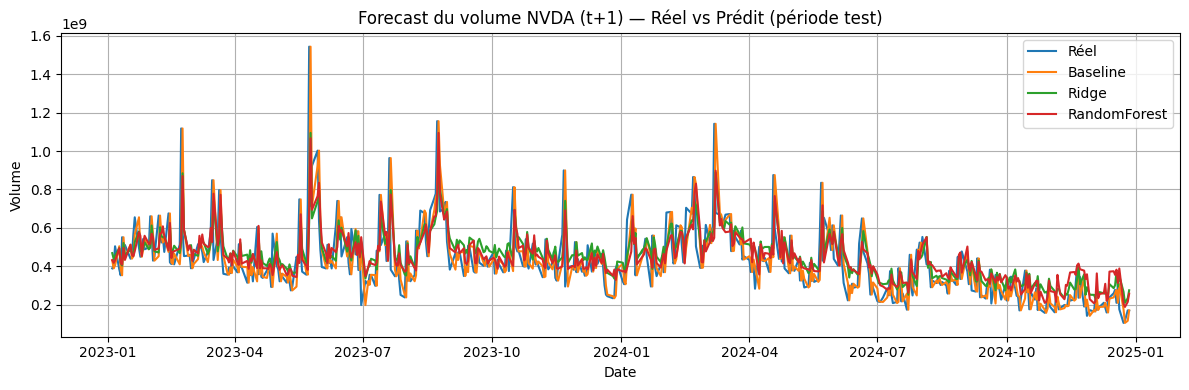

In [ ]:
test_dates = model_df["Date"].iloc[split:]

plt.figure(figsize=(12, 4))
plt.plot(test_dates, y_test.values, label="Réel")

plt.plot(test_dates, y_pred_baseline, label="Baseline")
plt.plot(test_dates, y_pred_ridge, label="Ridge")
plt.plot(test_dates, y_pred_rf, label="RandomForest")

plt.title("Forecast du volume NVDA (t+1) — Réel vs Prédit (période test)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

**Interprétations** :
1) **Comportement général (niveau et tendance)**  
Les trois approches suivent globalement le **niveau moyen** du volume sur la période test. Cela confirme que l’essentiel de la dynamique est bien capté par l’**inertie** du volume (d’où une baseline déjà performante).

2) **Comparaison baseline vs modèles**  
Visuellement, **Ridge** et **RandomForest** collent légèrement mieux au signal réel que la baseline sur de nombreuses périodes, ce qui est cohérent avec les résultats chiffrés (RMSE plus faible et \(R^2\) plus élevé).  
On observe en particulier que les modèles “lissent” moins certains écarts persistants et ajustent mieux les phases où le volume change de régime.

3) **Gestion des pics de volume**  
Les fortes pointes de volume restent difficiles à prévoir : elles sont souvent liées à des événements discrets (résultats, annonces, news, chocs macro) qui ne sont pas directement présents dans nos variables.  
On voit que les modèles réduisent parfois l’amplitude de l’erreur sur certains pics, mais **ne les anticipent pas parfaitement**. C’est typique en prévision de volume à horizon 1 jour : sans variables événementielles, une partie des extrêmes reste imprévisible.

4) **Différence Ridge vs RandomForest**  
Les courbes Ridge et RandomForest sont très proches. Cela suggère que, **avec les features actuelles**, la relation entre \(X_t\) et \(Volume_{t+1}\) est déjà assez bien captée par un modèle linéaire régularisé.  
RandomForest n’apporte pas de gain clair ici, ce qui est cohérent avec le tableau des métriques (Ridge légèrement meilleur en RMSE et \(R^2\)).


Cette visualisation confirme l’analyse quantitative : les features ajoutées améliorent la prévision par rapport à la baseline, mais la prédiction des journées “événementielles” reste la principale limite. Ridge apparaît comme un bon compromis performance/simplicité sur ce premier cadre.


---
## C.2 Comprendre “ce qui drive” les prédictions (interprétabilité)

Obtenir de bonnes métriques est nécessaire, mais pas suffisant : pour qu’un modèle soit crédible, on veut aussi comprendre **sur quels signaux** il s’appuie. Cette étape d’interprétabilité permet de vérifier deux choses :
1) que le modèle utilise des variables **cohérentes** avec l’intuition (inertie du volume, intensité des mouvements, régime de risque) ;
2) qu’il ne dépend pas excessivement d’un artefact ou d’une variable “surprise”.

On propose ici une lecture simple (et volontairement pragmatique) de l’importance des features :

- **Ridge** : après standardisation des variables, les **coefficients** donnent l’influence marginale de chaque feature sur la prédiction.  
  Le **signe** indique le sens (impact positif ou négatif) et la **valeur absolue** donne une idée de l’importance relative (toutes choses égales par ailleurs).

- **Random Forest** : l’attribut `feature_importances_` mesure quelles variables sont, en moyenne, les plus utiles pour réduire l’erreur dans les arbres (importance basée sur la diminution d’impureté).  
  Cette mesure ne donne pas un signe “+/-”, mais elle indique quelles variables sont les plus déterminantes pour les splits.

L’objectif n’est pas de produire une interprétation causale ou une analyse économétrique exhaustive, mais de vérifier que les modèles reposent sur des signaux plausibles et stables — et d’identifier les variables clés qui expliquent les gains de performance observés.


In [ ]:
# Importance Ridge : coefficients (features standardisées)
feat_names = X.columns

ridge_model = ridge.named_steps["model"]
ridge_coef = pd.Series(ridge_model.coef_, index=feat_names).sort_values(key=np.abs, ascending=False)

ridge_coef.head(10)

vol_lag1      1.485555e+08
vol_mean20    4.167564e+07
vol_mean5     1.763025e+07
vol20        -1.641415e+07
ret_QQQ      -1.469554e+07
ret_SOXX      1.372727e+07
VIXCLS        1.319188e+07
DGS10         1.162893e+07
dow           6.917988e+06
dVIX          3.729502e+06
dtype: float64

In [38]:
# Importance RandomForest : importance des variables dans les arbres
rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_imp.head(10)


vol_lag1        0.661569
vol_mean20      0.059921
vol20           0.045981
vol_mean5       0.040467
VIXCLS          0.033255
DGS10           0.024942
dVIX            0.021613
abs_ret_NVDA    0.020721
ret_SOXX        0.020642
ret_NVDA        0.017103
dtype: float64

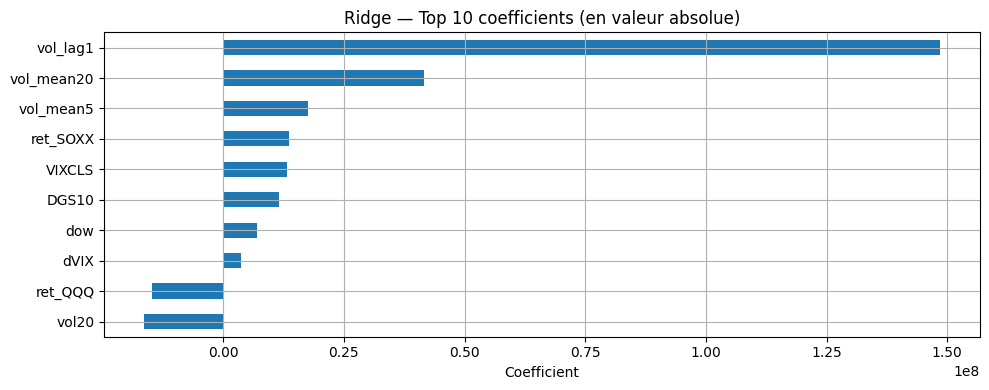

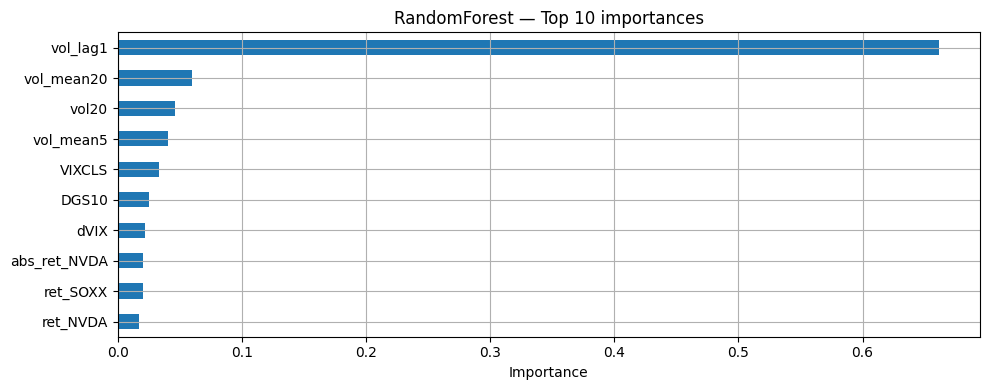

In [39]:
plt.figure(figsize=(10,4))
ridge_coef.head(10).sort_values().plot(kind="barh")
plt.title("Ridge — Top 10 coefficients (en valeur absolue)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
rf_imp.head(10).sort_values().plot(kind="barh")
plt.title("RandomForest — Top 10 importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid()
plt.show()


### Interprétation — Quelles variables “pilotent” les prédictions ?

#### 1) Ridge (coefficients)
Dans un modèle linéaire comme Ridge, **le signe** du coefficient indique le sens de l’effet (toutes choses égales par ailleurs) et **la magnitude** donne une idée de l’importance *à condition que les variables aient été standardisées* (sinon, les échelles dominent mécaniquement). 

Ce que montre le graphe :

- **`vol_lag1`** domine très largement : le meilleur prédicteur du volume de demain est… **le volume d’aujourd’hui**. On retrouve l’idée d’**inertie/persistance** du volume.
- **`vol_mean20`** puis **`vol_mean5`** viennent juste après : au-delà du jour précédent, le modèle utilise aussi le **niveau moyen récent** (tendance de fond du volume sur 1 à 4 semaines).
- Des variables de **contexte** apparaissent ensuite (`ret_SOXX`, `VIXCLS`, `DGS10`) : cela suggère qu’une partie de l’activité sur NVDA dépend aussi du **secteur** et du **régime de marché**.
- `dow` (jour de la semaine) est non nul : cela pointe un **effet calendrier** (même faible) sur l’activité.
- `ret_QQQ` et `vol20` ressortent avec un coefficient **négatif** dans ce top 10 : ce signe doit être interprété avec prudence, car plusieurs variables sont corrélées entre elles (lags/moyennes, vol20/VIX, etc.). En présence de corrélations, un coefficient peut changer de signe sans que cela contredise l’intuition économique : il s’agit d’un effet **conditionnel aux autres features**. :contentReference[oaicite:1]{index=1}

#### 2) Random Forest (feature importances)
Pour la Random Forest, `feature_importances_` mesure l’importance “MDI” (réduction moyenne d’impureté) : c’est une mesure utile, mais qui peut être biaisée et doit être lue comme une **hiérarchie indicative**. :contentReference[oaicite:2]{index=2}

Ce que montre le graphe :

- **`vol_lag1`** est encore **ultra-dominant** : la forêt confirme que l’inertie du volume est le signal principal.
- Ensuite, la forêt met en avant **`vol_mean20`**, **`vol20`** et **`vol_mean5`** : elle exploite clairement un mix **niveau récent du volume + régime de volatilité**.
- Les variables de régime/contexte (`VIXCLS`, `DGS10`, `dVIX`) comptent, mais restent secondaires.
- Les variables “prix” (`abs_ret_NVDA`, `ret_SOXX`, `ret_NVDA`) apparaissent, mais avec une importance plus faible : elles apportent de l’info, mais moins structurante que l’historique de volume.


En gros :
Les deux modèles racontent la même histoire :
1) le volume est avant tout **auto-prédictif** (lags + moyennes glissantes),  
2) la **volatilité / le régime de risque** ajoute une information utile,  
3) les rendements (NVDA/ETFs) jouent un rôle plus **secondaire**.

Autrement dit, pour un forecast à \(t+1\), l’essentiel de la performance vient de la **dynamique interne du volume**, puis du **régime de marché** (stress / conditions financières), plutôt que des rendements seuls.


---
## C.3 Validation croisée temporelle (TimeSeriesSplit)
(selon cours d'économétrie I, 2A S1)

Jusqu’ici, l’évaluation reposait sur **un seul split chronologique** (80% train / 20% test). C’est une première étape saine (on respecte l’ordre du temps), mais elle a une limite importante : **les résultats peuvent dépendre fortement de la date de coupure**. Sur des séries financières, où l’on observe souvent des **changements de régime** (périodes calmes vs stress, bull vs corrections), un modèle peut sembler très bon simplement parce qu’il “tombe” sur un test facile — ou l’inverse. L’objectif de cette section est donc de rendre l’évaluation **plus robuste** et plus crédible. 

### Pourquoi une validation croisée en séries temporelles ?

On veut estimer la performance sur des données “nouvelles”. En séries temporelles, on ne peut pas utiliser une validation croisée classique de type *K-Fold* (qui mélange le passé et le futur), car cela créerait une **fuite d’information** : le modèle pourrait être entraîné sur des observations postérieures à celles du test. 

La bonne pratique consiste à reproduire le scénario réel : **on entraîne sur le passé, on teste sur le futur** — et on répète ce scénario plusieurs fois à différentes dates.

### Principe de `TimeSeriesSplit` (walk-forward / fenêtre croissante)

`TimeSeriesSplit` découpe la série en plusieurs “folds” consécutifs :

- à chaque fold, on entraîne le modèle sur une période historique (**train**),
- puis on l’évalue sur la période suivante (**test**),
- la fenêtre d’entraînement **s’agrandit au fil des folds** (logique de “fenêtre croissante”), ce qui correspond bien à une situation où l’on accumule des données au cours du temps.

L’intérêt est double :
1) on obtient plusieurs évaluations “train → futur”, donc une estimation plus stable ;
2) on peut mesurer la **variabilité** des performances : un modèle vraiment fiable doit être bon **de façon régulière**, pas uniquement sur une seule période.


### Point d’attention spécifique ici : horizon \(t+1\) et “gap” (éviter la fuite à la frontière)

Notre cible est Volume_{t+1}, construite avec `shift(-1)`. Cela signifie qu’une ligne datée t “porte” une cible située au jour suivant.

Conséquence : à la frontière entre train et test, il faut éviter que les **dernières lignes du train** aient une cible qui tombe **dans la fenêtre test** (sinon on apprend indirectement sur une partie du futur évalué). Pour sécuriser ce point, on introduit un **écart d’un pas** entre train et test (un *gap* de 1 observation), ce qui garantit que les cibles utilisées pour l’entraînement restent strictement dans le passé par rapport à la période de test. 


### Ce qui sera produit dans cette section

Pour chaque modèle (baseline, Ridge, Random Forest), on :
- entraîne et prédit sur chacun des folds,
- calcule les métriques (MAE, RMSE, \(R^2\)) sur chaque fold,
- puis résume par une **moyenne** (niveau de performance) et un **écart-type** (stabilité).

La conclusion recherchée est simple : identifier le modèle qui est **à la fois performant et stable** dans le temps, dans un cadre de prévision réaliste. 


In [75]:
tscv = TimeSeriesSplit(n_splits=5)#on chosit 5 splits

def eval_cv(model, X, y, tscv, *, baseline_series=None, gap=1):
    rows = []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):

        # "gap" : on enlève les dernières observations du train dont la cible tomberait dans le test
        # (car y_t = Volume_{t+1} via shift(-1))
        first_test = test_idx[0]
        if gap > 0:
            train_idx = train_idx[train_idx < (first_test - gap)]
        if len(train_idx) == 0:
            raise ValueError(f"Fold {fold}: train vide après application du gap={gap}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if model is None:
            if baseline_series is None:
                raise ValueError("baseline_series doit être fourni pour évaluer la baseline.")
            y_pred = baseline_series.iloc[test_idx].values
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        m = report_metrics(y_test, y_pred, name=f"fold_{fold}")
        rows.append(m)

    return pd.DataFrame(rows)

# Fonction qui affiche les résultast
def summarize(cv_df, name):
    return pd.Series({
        "Model": name,
        "MAE_mean":  cv_df["MAE"].mean(),
        "MAE_std":   cv_df["MAE"].std(),
        "RMSE_mean": cv_df["RMSE"].mean(),
        "RMSE_std":  cv_df["RMSE"].std(),
        "R2_mean":   cv_df["R2"].mean(),
        "R2_std":    cv_df["R2"].std(),
    })

# Baseline : yhat_{t+1} = Volume_t  (ici vol_lag1 est déjà dans X)
baseline_cv = eval_cv(None, X, y, tscv, baseline_series=X["vol_lag1"], gap=1)

# Ridge : standardisation + régularisation L2
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])
ridge_cv = eval_cv(ridge_model, X, y, tscv, gap=1)

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_cv = eval_cv(rf_model, X, y, tscv, gap=1)

# Résumé (moyenne ± écart-type sur les folds)
cv_summary = pd.DataFrame([
    summarize(baseline_cv, "Baseline (ŷ=Volume_t)"),
    summarize(ridge_cv, "Ridge"),
    summarize(rf_cv, "RandomForest"),
]).set_index("Model")

display(cv_summary.round(3))


,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
Model,,,,,,
Baseline (ŷ=Volume_t),1.266321e+08,4.447638e+07,1.930811e+08,7.713794e+07,0.311,0.118
Ridge,1.298066e+08,5.657842e+07,1.910010e+08,9.814952e+07,0.352,0.196
RandomForest,1.314110e+08,4.632145e+07,1.927728e+08,9.231189e+07,0.331,0.171


### Interprétation  de la Validation croisée temporelle (TimeSeriesSplit)

Le tableau ci-dessus résume les performances **moyennes** et leur **variabilité** (écart-type) sur plusieurs découpages chronologiques *train → test*. Cette évaluation est plus robuste qu’un unique split, car elle mesure la performance du modèle sur **différentes périodes de marché** (régimes calmes vs stress).

#### 1) Une baseline difficile à battre
La baseline (via `vol_lag1`) obtient déjà de bonnes performances : cela confirme une propriété classique du volume, à savoir une forte **persistance** (inertie). Dans ce contexte, un modèle plus complexe doit apporter une information réellement complémentaire pour améliorer nettement les métriques.

#### 2) Ridge : gain surtout sur les erreurs extrêmes
- Ridge améliore légèrement la **RMSE moyenne** et le **\(R^2\)** par rapport à la baseline (RMSE_mean plus faible, \(R^2\)_mean plus élevé).  
  Comme la RMSE pénalise davantage les grosses erreurs, cela suggère que Ridge gère un peu mieux certains épisodes atypiques (pics de volume / changements de régime).
- En revanche, la **MAE moyenne** est légèrement moins bonne que la baseline. Cela indique que l’amélioration concerne surtout les **grosses erreurs**, sans forcément réduire l’erreur “typique” sur les journées ordinaires.

#### 3) Random Forest : pas de gain net dans ce paramétrage
La Random Forest n’apporte pas ici d’amélioration claire par rapport à la baseline, et reste légèrement en dessous de Ridge sur RMSE et \(R^2\). Ce résultat est cohérent : lorsque `vol_lag1` et des moyennes glissantes expliquent déjà une grande partie de la dynamique, un modèle non-linéaire n’a pas nécessairement un avantage immédiat (surtout sans réglage fin des hyperparamètres).

#### 4) Stabilité : des performances qui varient selon les périodes
Les écarts-types (notamment sur \(R^2\)) sont relativement élevés, ce qui montre que la performance dépend fortement du **fold** considéré : certaines périodes sont plus faciles à prévoir que d’autres (régimes de marché différents). C’est précisément l’intérêt de TimeSeriesSplit : évaluer non seulement le niveau moyen de performance, mais aussi sa **robustesse dans le temps**.

**Conclusion.** Dans ce cadre de validation temporelle, la baseline capture déjà une grande partie du signal. Ridge apporte un gain modeste (surtout sur RMSE/\(R^2\)), tandis que la Random Forest ne surperforme pas nettement avec cette configuration.


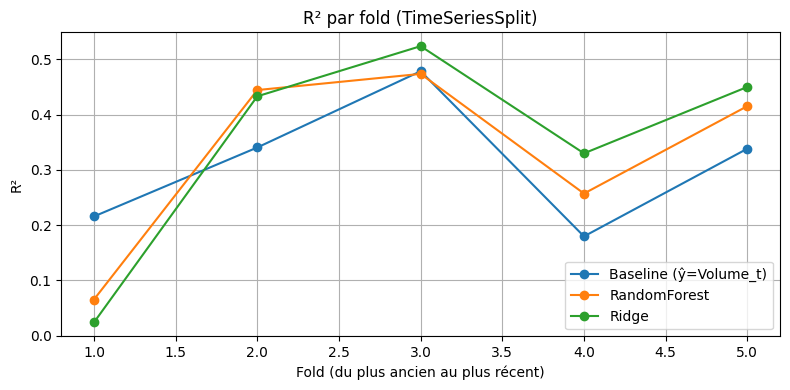

In [ ]:
#Table fold-by-fold (déjà calculée : baseline_cv, ridge_cv, rf_cv)
fold_table = pd.concat(
    [
        baseline_cv.assign(Model="Baseline (ŷ=Volume_t)"),
        ridge_cv.assign(Model="Ridge"),
        rf_cv.assign(Model="RandomForest"),
    ],
    axis=0
).reset_index(drop=True)

#Ajout d'un identifiant de fold (1..n_splits) : chaque df contient une ligne par fold, dans l'ordre
n_folds = fold_table.groupby("Model").size().iloc[0]
fold_table["Fold"] = list(range(1, n_folds + 1)) * fold_table["Model"].nunique()

# Pivot lisible : une ligne par fold, colonnes = modèles
def pivot_metric(metric):
    return fold_table.pivot(index="Fold", columns="Model", values=metric)

#plot le tout
r2_p = pivot_metric("R2")

plt.figure(figsize=(8, 4))
for col in r2_p.columns:
    plt.plot(r2_p.index, r2_p[col], marker="o", label=col)
plt.title("R² par fold (TimeSeriesSplit)")
plt.xlabel("Fold (du plus ancien au plus récent)")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

L’objectif est d’aller plus loin que la simple moyenne ± écart-type, en regardant **fold par fold** ce que valent les modèles.

Les tableaux fold-by-fold montrent que la performance n’est pas constante : elle varie selon les périodes de test. C’est attendu sur une série financière, car le volume et la volatilité évoluent souvent par **régimes**.

- Si un modèle est **meilleur en moyenne** mais très instable, il peut être performant uniquement sur certaines périodes.
- À l’inverse, un modèle légèrement moins bon en moyenne mais **plus stable** peut être préférable, car il généralise mieux dans le temps.

Le graphe du \(R^2\) par fold permet de repérer immédiatement :
- les périodes où tous les modèles sont “à l’aise” (folds faciles),
- et celles où les performances chutent simultanément (folds difficiles), souvent associées à des épisodes de rupture ou à des changements de régime (pics de volume, stress, dynamique différente du passé).

L’affichage des dates de test par fold sert justement à ancrer cette lecture dans le temps : on peut commenter que les folds difficiles correspondent à une fenêtre où la dynamique du volume devient moins “auto-prédictible” et plus dominée par des chocs.


# Conclusion générale du projet

## Rappels des points importants de chaque partie

**Partie A — Données.**
Nous avez construit et nettoyé une base exploitable en fusionnant trois sources : 
- (i) NVDA  
- (ii) ETFs  
- (iii) variables macro/risque 

**Partie B — Visualisation.**
L’EDA met en évidence : 
- (i) une trajectoire très non-linéaire de la progression du cours de NVIDIA (volume/prix) sur 2015–2024 (phases d’accélération et ralentissment), 
- (ii) des rendements avec **queues épaisses** et alternance de régimes, 
- (iii) un lien empirique clair entre **activité (volume)** et **amplitude des mouvements de prix / volatilité**,  
- (iv) l’intérêt d’ajouter des variables de contexte (secteur/risque) plutôt que de rester univarié. 

Ces faits stylisés sont classiques en finance : relation volume–variabilité des prix et clustering de volatilité.

**Partie C — Modélisation (forecast du volume à (t+1)).**
Le message central est robuste : le volume est **fortement auto-prédictible** (feature `vol_lag1` dominante), et les modèles multivariés n’apportent qu’un supplément limité, surtout quand on évalue correctement en chronologique. 

- Ridge ressort comme amélioration “safe” (stabilité/robustesse), 
- Tandis que Random Forest n’apporte pas de gain net sans tuning plus poussé et sans travail supplémentaire sur les régimes.

## Réponse à la problématique

Sur 2015–2024, “l’explosion” boursière de NVDA se lit dans les graphiques par une **hausse de long terme** ponctuée de **phases de stress/accélération** (volatilité et drawdowns), et par des épisodes où l’activité de marché (volume) se tend fortement lorsque l’incertitude et l’amplitude des rendements augmentent — ce qui est cohérent avec les mécanismes documentés “volume ↔ information/volatilité”. 

Côté “méthodes de prévision”, l'étude montre surtout une limite importante (et intéressante) : **à horizon (t+1), la prévision du volume est dominée par la persistance**, et l’amélioration marginale vient davantage de la **stabilisation** (Ridge) que d’une complexité non-linéaire “brute”. C’est une conclusion méthodologiquement : 
- (i) baseline forte, 
- (ii) gains modestes mais réels via régularisation, 
- (iii) performances instables selon les régimes → difficulté structurelle de prévoir les chocs.

## Considérations d’ouverture

1. **Aller au-delà de (t+1)** : tester plusieurs horizons (5j, 20j) et comparer la dégradation des performances (ce qui documente la “mémoire” utile).
2. **Hyperparamètres et sélection de variables** : nested CV temporelle + recherche d’hyperparamètres (surtout pour Random Forest), et importance par **permutation** plutôt que l’impurity-based seule (biais connue). 
3. **Événements et “news flow”** : earnings dates, annonces produits, ou variables d’options (implied vol) pour capter les pics de volume non expliqués par l’inertie. (C'était notre sujet initial)